<a href="https://colab.research.google.com/github/Krisanthi/Customer-Churn-Prediction-Model/blob/main/CM2604_Churn_Prediction_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# CM2604 Machine Learning Coursework
## Telco Customer Churn Prediction

**Module:** CM2604 Machine Learning  
**RGU Student ID:** 2425596  
**IIT Student ID:** 20232384  
**Student Name:** Krisanthi Segar  

---

### Project Overview
This project aims to predict customer churn in a telecommunications company using machine learning techniques. I implement and compare a **Decision Tree Classifier** (with GridSearchCV hyperparameter tuning) and a **Neural Network** model.

**Dataset:** Telco Customer Churn (Kaggle)  
**Target Variable:** Churn (Yes/No - Binary Classification)  
**Models:** Decision Tree Classifier, Neural Network (MLP)

---
# 1. Setup and Data Loading
---

In [1]:
# Install required packages
!pip install scikit-learn==1.3.2 imbalanced-learn==0.11.0 -q
print("Packages installed successfully!")

Packages installed successfully!


In [2]:
# Import necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, classification_report,
                             confusion_matrix, ConfusionMatrixDisplay)
from scipy.stats import zscore
from scipy import stats
from imblearn.over_sampling import SMOTE
from collections import Counter

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

from google.colab import files

# Set seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Set display options
pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')

print("All libraries imported successfully!")
print(f"TensorFlow version: {tf.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

All libraries imported successfully!
TensorFlow version: 2.19.0
NumPy version: 1.26.4
Pandas version: 2.2.2


In [3]:
# Upload the dataset
print("Please upload the 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file")
uploaded = files.upload()
filename = list(uploaded.keys())[0]
print(f"\nFile '{filename}' uploaded successfully!")

Please upload the 'WA_Fn-UseC_-Telco-Customer-Churn.csv' file


Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv

File 'WA_Fn-UseC_-Telco-Customer-Churn (1).csv' uploaded successfully!


In [4]:
# Load the dataset
df = pd.read_csv(filename)
data = df.copy()

print("=" * 70)
print("DATASET LOADED SUCCESSFULLY")
print("=" * 70)
print(f"\nDataset shape: {data.shape}")
print(f"Number of records: {data.shape[0]:,}")
print(f"Number of features: {data.shape[1]}")

# Display first few rows
print("\n--- First 5 Rows ---")
display(data.head())

DATASET LOADED SUCCESSFULLY

Dataset shape: (7043, 21)
Number of records: 7,043
Number of features: 21

--- First 5 Rows ---


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


---
# TASK 1: Exploratory Data Analysis (EDA)
---

## 1.1 Dataset Overview

In [5]:
# Dataset Information
print("=" * 70)
print("DATASET INFORMATION")
print("=" * 70)
data.info()

print("\n--- Column Names and Data Types ---")
for i, (col, dtype) in enumerate(zip(data.columns, data.dtypes), 1):
    print(f"{i:2}. {col:20} - {dtype}")

DATASET INFORMATION
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7043

In [6]:
# Missing Values Analysis
print("=" * 70)
print("MISSING VALUES ANALYSIS")
print("=" * 70)

# Standard null check
print("\n--- Standard Null Check ---")
null_counts = data.isnull().sum()
print(null_counts[null_counts > 0] if null_counts.sum() > 0 else "No standard null values found")

# TotalCharges special case - contains spaces as blanks
print(f"\nTotalCharges data type (before conversion): {data['TotalCharges'].dtype}")

# Check for empty strings/spaces in TotalCharges
empty_tc = data['TotalCharges'].replace(' ', '').eq('')
print(f"Empty strings/spaces in TotalCharges: {empty_tc.sum()}")

# Convert to numeric to reveal true missing values
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
missing_tc = data['TotalCharges'].isnull().sum()
print(f"\nAfter converting to numeric:")
print(f"Missing values in TotalCharges: {missing_tc}")
print(f"Percentage of missing: {(missing_tc / len(data)) * 100:.2f}%")

# Show rows with missing TotalCharges
if missing_tc > 0:
    print("\n--- Rows with Missing TotalCharges ---")
    display(data[data['TotalCharges'].isnull()][['customerID', 'tenure', 'MonthlyCharges', 'TotalCharges', 'Churn']])
    print("\nObservation: Missing TotalCharges are for customers with tenure=0 (new customers)")

MISSING VALUES ANALYSIS

--- Standard Null Check ---
No standard null values found

TotalCharges data type (before conversion): object
Empty strings/spaces in TotalCharges: 11

After converting to numeric:
Missing values in TotalCharges: 11
Percentage of missing: 0.16%

--- Rows with Missing TotalCharges ---


,customerID,tenure,MonthlyCharges,TotalCharges,Churn
488,4472-LVYGI,0,52.55,NaN,No
753,3115-CZMZD,0,20.25,NaN,No
936,5709-LVOEQ,0,80.85,NaN,No
1082,4367-NUYAO,0,25.75,NaN,No
1340,1371-DWPAZ,0,56.05,NaN,No
3331,7644-OMVMY,0,19.85,NaN,No
3826,3213-VVOLG,0,25.35,NaN,No
4380,2520-SGTTA,0,20.00,NaN,No
5218,2923-ARZLG,0,19.70,NaN,No
6670,4075-WKNIU,0,73.35,NaN,No



Observation: Missing TotalCharges are for customers with tenure=0 (new customers)


In [7]:
# Duplicate Analysis
print("=" * 70)
print("DUPLICATE ANALYSIS")
print("=" * 70)
print(f"Duplicate rows in dataset: {data.duplicated().sum()}")
print(f"Duplicate customerIDs: {data['customerID'].duplicated().sum()}")
print(f"Unique customers: {data['customerID'].nunique():,}")

DUPLICATE ANALYSIS
Duplicate rows in dataset: 0
Duplicate customerIDs: 0
Unique customers: 7,043


## 1.2 Numerical Features Analysis

In [8]:
# Numerical Features Statistics
print("=" * 70)
print("NUMERICAL FEATURES ANALYSIS")
print("=" * 70)

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
print("\n--- Statistical Summary ---")
display(data[numerical_cols].describe().round(2))

print("\n--- Key Observations ---")
print(f"\nTenure:")
print(f"  Range: {data['tenure'].min()} to {data['tenure'].max()} months")
print(f"  Mean: {data['tenure'].mean():.1f} months")
print(f"  Median: {data['tenure'].median():.1f} months")

print(f"\nMonthlyCharges:")
print(f"  Range: ${data['MonthlyCharges'].min():.2f} to ${data['MonthlyCharges'].max():.2f}")
print(f"  Mean: ${data['MonthlyCharges'].mean():.2f}")

print(f"\nTotalCharges:")
print(f"  Range: ${data['TotalCharges'].min():.2f} to ${data['TotalCharges'].max():.2f}")
print(f"  Mean: ${data['TotalCharges'].mean():.2f}")

NUMERICAL FEATURES ANALYSIS

--- Statistical Summary ---


,tenure,MonthlyCharges,TotalCharges
count,7043.00,7043.00,7032.00
mean,32.37,64.76,2283.30
std,24.56,30.09,2266.77
min,0.00,18.25,18.80
25%,9.00,35.50,401.45
50%,29.00,70.35,1397.48
75%,55.00,89.85,3794.74
max,72.00,118.75,8684.80



--- Key Observations ---

Tenure:
  Range: 0 to 72 months
  Mean: 32.4 months
  Median: 29.0 months

MonthlyCharges:
  Range: $18.25 to $118.75
  Mean: $64.76

TotalCharges:
  Range: $18.80 to $8684.80
  Mean: $2283.30


## 1.3 Categorical Features Analysis

In [9]:
# Categorical Features Analysis
print("=" * 70)
print("CATEGORICAL FEATURES ANALYSIS")
print("=" * 70)

categorical_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                    'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
                    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
                    'Contract', 'PaperlessBilling', 'PaymentMethod']

print(f"\nNumber of Categorical Features: {len(categorical_cols)}")

# Check unique values per categorical column
print("\n--- Unique Values per Column ---")
for col in categorical_cols:
    unique_vals = data[col].unique()
    print(f"{col}: {len(unique_vals)} unique values - {list(unique_vals)}")

CATEGORICAL FEATURES ANALYSIS

Number of Categorical Features: 16

--- Unique Values per Column ---
gender: 2 unique values - ['Female', 'Male']
SeniorCitizen: 2 unique values - [0, 1]
Partner: 2 unique values - ['Yes', 'No']
Dependents: 2 unique values - ['No', 'Yes']
PhoneService: 2 unique values - ['No', 'Yes']
MultipleLines: 3 unique values - ['No phone service', 'No', 'Yes']
InternetService: 3 unique values - ['DSL', 'Fiber optic', 'No']
OnlineSecurity: 3 unique values - ['No', 'Yes', 'No internet service']
OnlineBackup: 3 unique values - ['Yes', 'No', 'No internet service']
DeviceProtection: 3 unique values - ['No', 'Yes', 'No internet service']
TechSupport: 3 unique values - ['No', 'Yes', 'No internet service']
StreamingTV: 3 unique values - ['No', 'Yes', 'No internet service']
StreamingMovies: 3 unique values - ['No', 'Yes', 'No internet service']
Contract: 3 unique values - ['Month-to-month', 'One year', 'Two year']
PaperlessBilling: 2 unique values - ['Yes', 'No']
PaymentMeth

In [10]:
# Value counts for key categorical features
print("\n--- Value Distributions (Key Features) ---")
key_features = ['Contract', 'InternetService', 'PaymentMethod', 'gender']

for col in key_features:
    print(f"\n{col}:")
    vc = data[col].value_counts()
    for val, count in vc.items():
        pct = (count / len(data)) * 100
        print(f"  {val}: {count:,} ({pct:.1f}%)")


--- Value Distributions (Key Features) ---

Contract:
  Month-to-month: 3,875 (55.0%)
  Two year: 1,695 (24.1%)
  One year: 1,473 (20.9%)

InternetService:
  Fiber optic: 3,096 (44.0%)
  DSL: 2,421 (34.4%)
  No: 1,526 (21.7%)

PaymentMethod:
  Electronic check: 2,365 (33.6%)
  Mailed check: 1,612 (22.9%)
  Bank transfer (automatic): 1,544 (21.9%)
  Credit card (automatic): 1,522 (21.6%)

gender:
  Male: 3,555 (50.5%)
  Female: 3,488 (49.5%)


DETAILED BAR CHART ANALYSIS FOR CATEGORICAL FEATURES


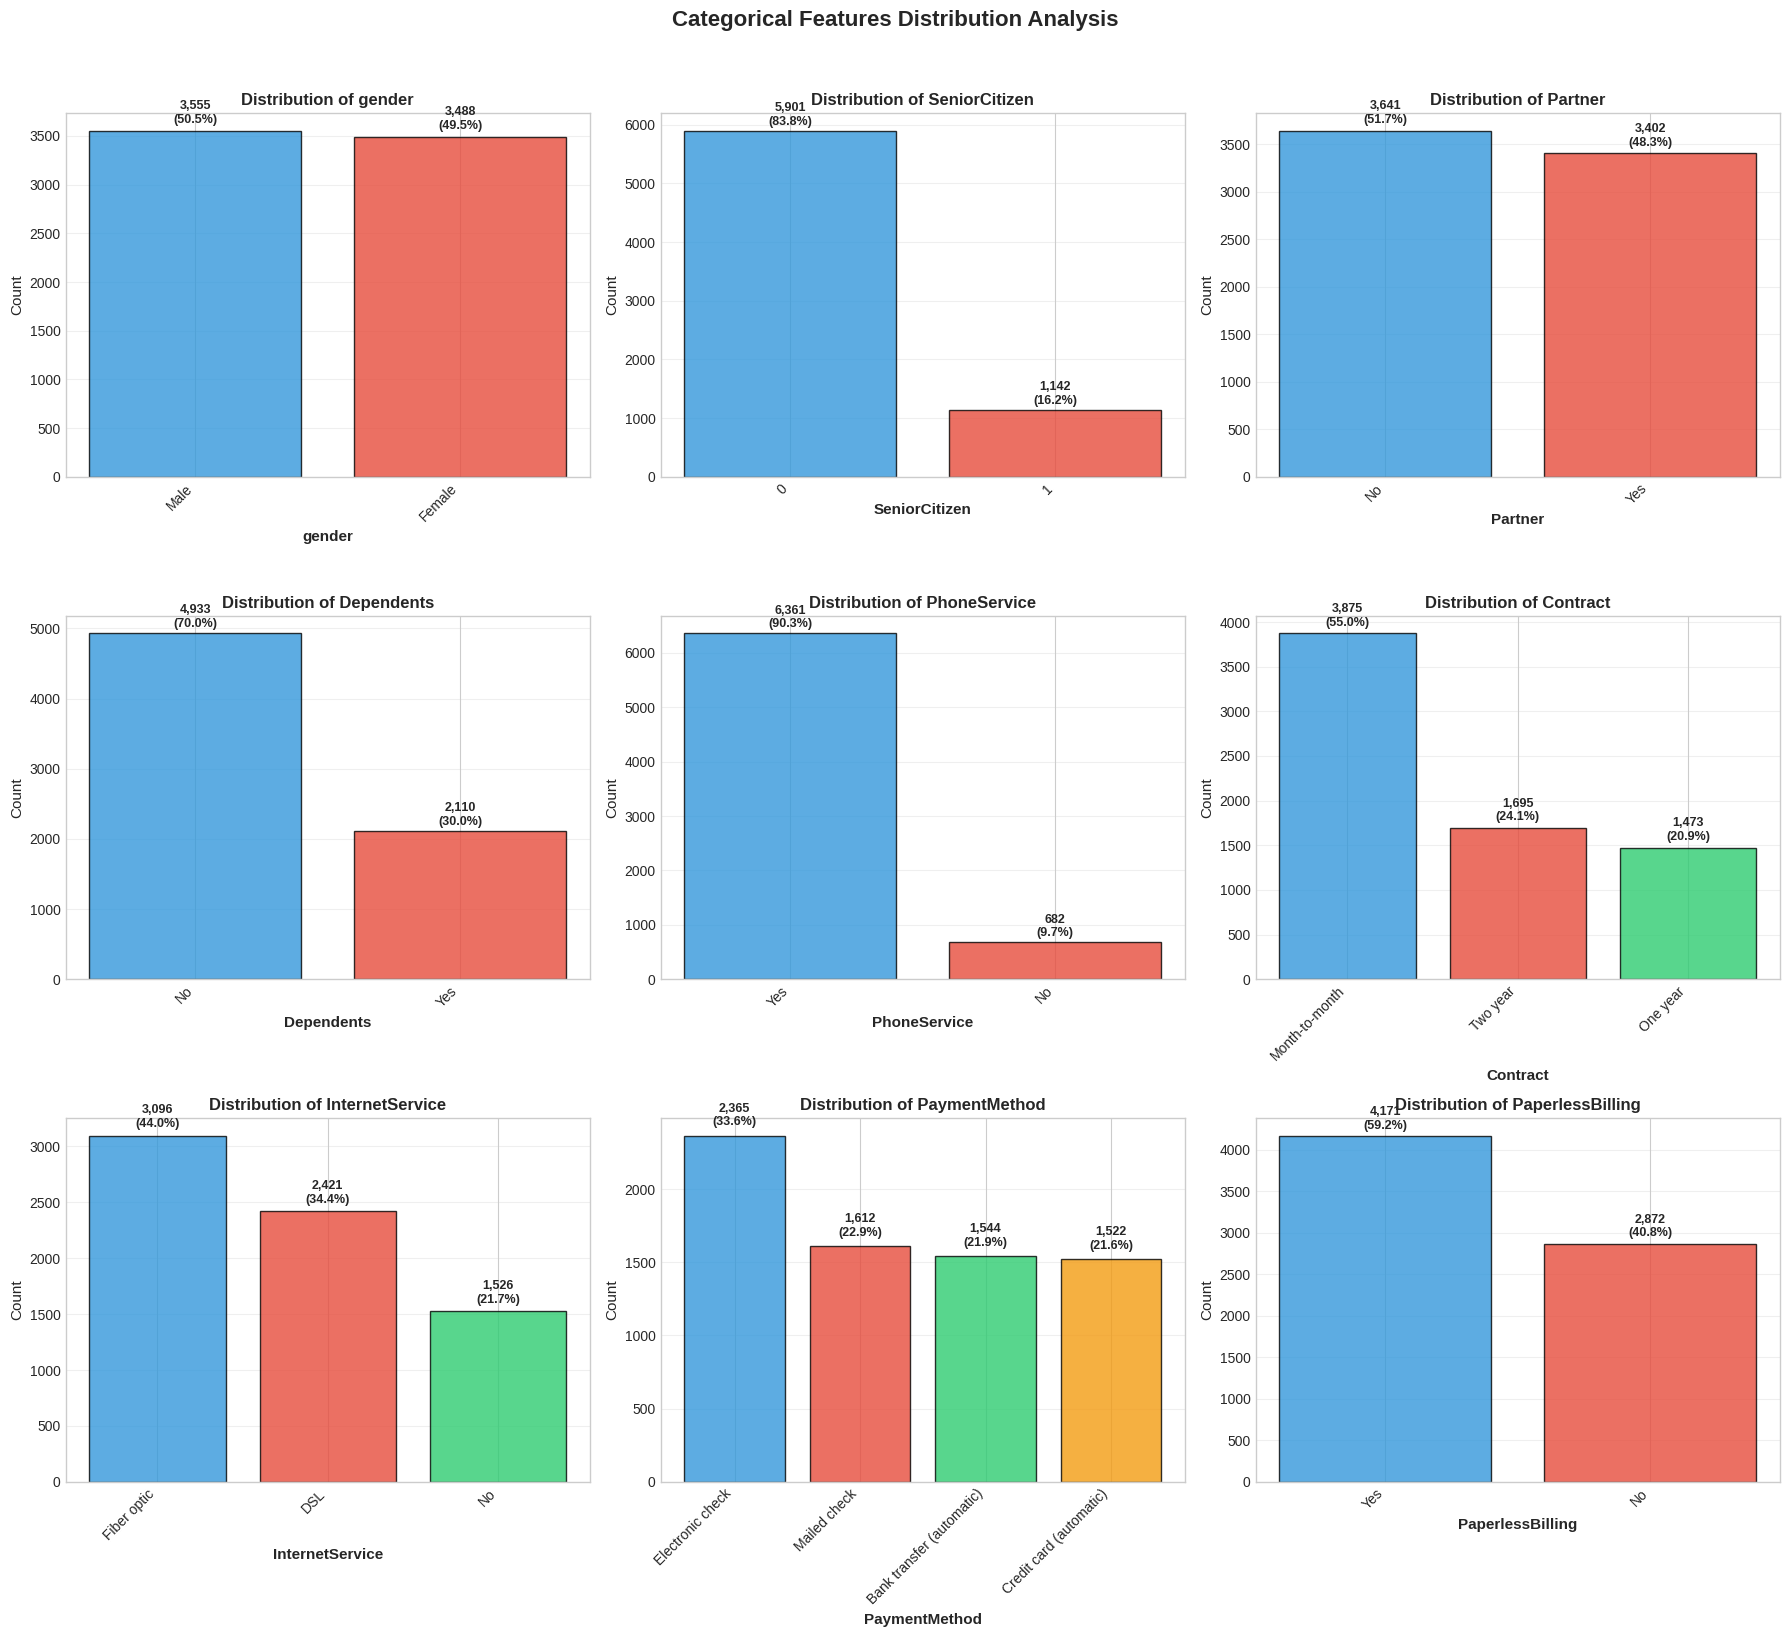


CATEGORICAL FEATURES SUMMARY

GENDER:
----------------------------------------
  • Male: 3,555 (50.48%)
  • Female: 3,488 (49.52%)

SENIORCITIZEN:
----------------------------------------
  • 0: 5,901 (83.79%)
  • 1: 1,142 (16.21%)

PARTNER:
----------------------------------------
  • No: 3,641 (51.70%)
  • Yes: 3,402 (48.30%)

DEPENDENTS:
----------------------------------------
  • No: 4,933 (70.04%)
  • Yes: 2,110 (29.96%)

PHONESERVICE:
----------------------------------------
  • Yes: 6,361 (90.32%)
  • No: 682 (9.68%)

CONTRACT:
----------------------------------------
  • Month-to-month: 3,875 (55.02%)
  • Two year: 1,695 (24.07%)
  • One year: 1,473 (20.91%)

INTERNETSERVICE:
----------------------------------------
  • Fiber optic: 3,096 (43.96%)
  • DSL: 2,421 (34.37%)
  • No: 1,526 (21.67%)

PAYMENTMETHOD:
----------------------------------------
  • Electronic check: 2,365 (33.58%)
  • Mailed check: 1,612 (22.89%)
  • Bank transfer (automatic): 1,544 (21.92%)
  • Credit c

In [11]:
# ============================================================================
# DETAILED BAR CHARTS FOR CATEGORICAL FEATURES
# ============================================================================

print("=" * 70)
print("DETAILED BAR CHART ANALYSIS FOR CATEGORICAL FEATURES")
print("=" * 70)

# Key categorical features to visualize
categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                        'PhoneService', 'Contract', 'InternetService',
                        'PaymentMethod', 'PaperlessBilling']

# Create subplots grid
fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.flatten()

colors_palette = ['#3498db', '#e74c3c', '#2ecc71', '#f39c12', '#9b59b6', '#1abc9c']

for idx, col in enumerate(categorical_features):
    ax = axes[idx]

    # Get value counts
    value_counts = data[col].value_counts()

    # Create bar chart
    bars = ax.bar(range(len(value_counts)), value_counts.values,
                  color=colors_palette[:len(value_counts)], edgecolor='black', alpha=0.8)

    # Add value labels on bars
    for i, (bar, val) in enumerate(zip(bars, value_counts.values)):
        percentage = val / len(data) * 100
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                f'{val:,}\n({percentage:.1f}%)', ha='center', va='bottom', fontsize=9, fontweight='bold')

    ax.set_xticks(range(len(value_counts)))
    ax.set_xticklabels(value_counts.index, rotation=45, ha='right')
    ax.set_xlabel(col, fontsize=11, fontweight='bold')
    ax.set_ylabel('Count', fontsize=11)
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')

plt.suptitle('Categorical Features Distribution Analysis', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('categorical_features_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# Print summary statistics for each categorical feature
print("\n" + "=" * 70)
print("CATEGORICAL FEATURES SUMMARY")
print("=" * 70)

for col in categorical_features:
    print(f"\n{col.upper()}:")
    print("-" * 40)
    value_counts = data[col].value_counts()
    for category, count in value_counts.items():
        percentage = count / len(data) * 100
        print(f"  • {category}: {count:,} ({percentage:.2f}%)")

print("\n" + "=" * 70)
print("Categorical features analysis complete!")
print("=" * 70)

## 1.4 Target Variable Analysis

In [12]:
# Target Variable Analysis
print("=" * 70)
print("TARGET VARIABLE ANALYSIS (Churn)")
print("=" * 70)

target_counts = data['Churn'].value_counts()
target_pct = data['Churn'].value_counts(normalize=True) * 100

print(f"\nChurn Distribution:")
print(f"  No (Did not churn):  {target_counts['No']:,} ({target_pct['No']:.2f}%)")
print(f"  Yes (Churned):       {target_counts['Yes']:,} ({target_pct['Yes']:.2f}%)")

imbalance_ratio = target_counts['No'] / target_counts['Yes']
print(f"\nClass Imbalance Ratio: {imbalance_ratio:.2f}:1 (No:Yes)")
print("\n** Dataset exhibits significant class imbalance - SMOTE will be applied **")

TARGET VARIABLE ANALYSIS (Churn)

Churn Distribution:
  No (Did not churn):  5,174 (73.46%)
  Yes (Churned):       1,869 (26.54%)

Class Imbalance Ratio: 2.77:1 (No:Yes)

** Dataset exhibits significant class imbalance - SMOTE will be applied **


CHURN RATE ANALYSIS BY CATEGORICAL FEATURES


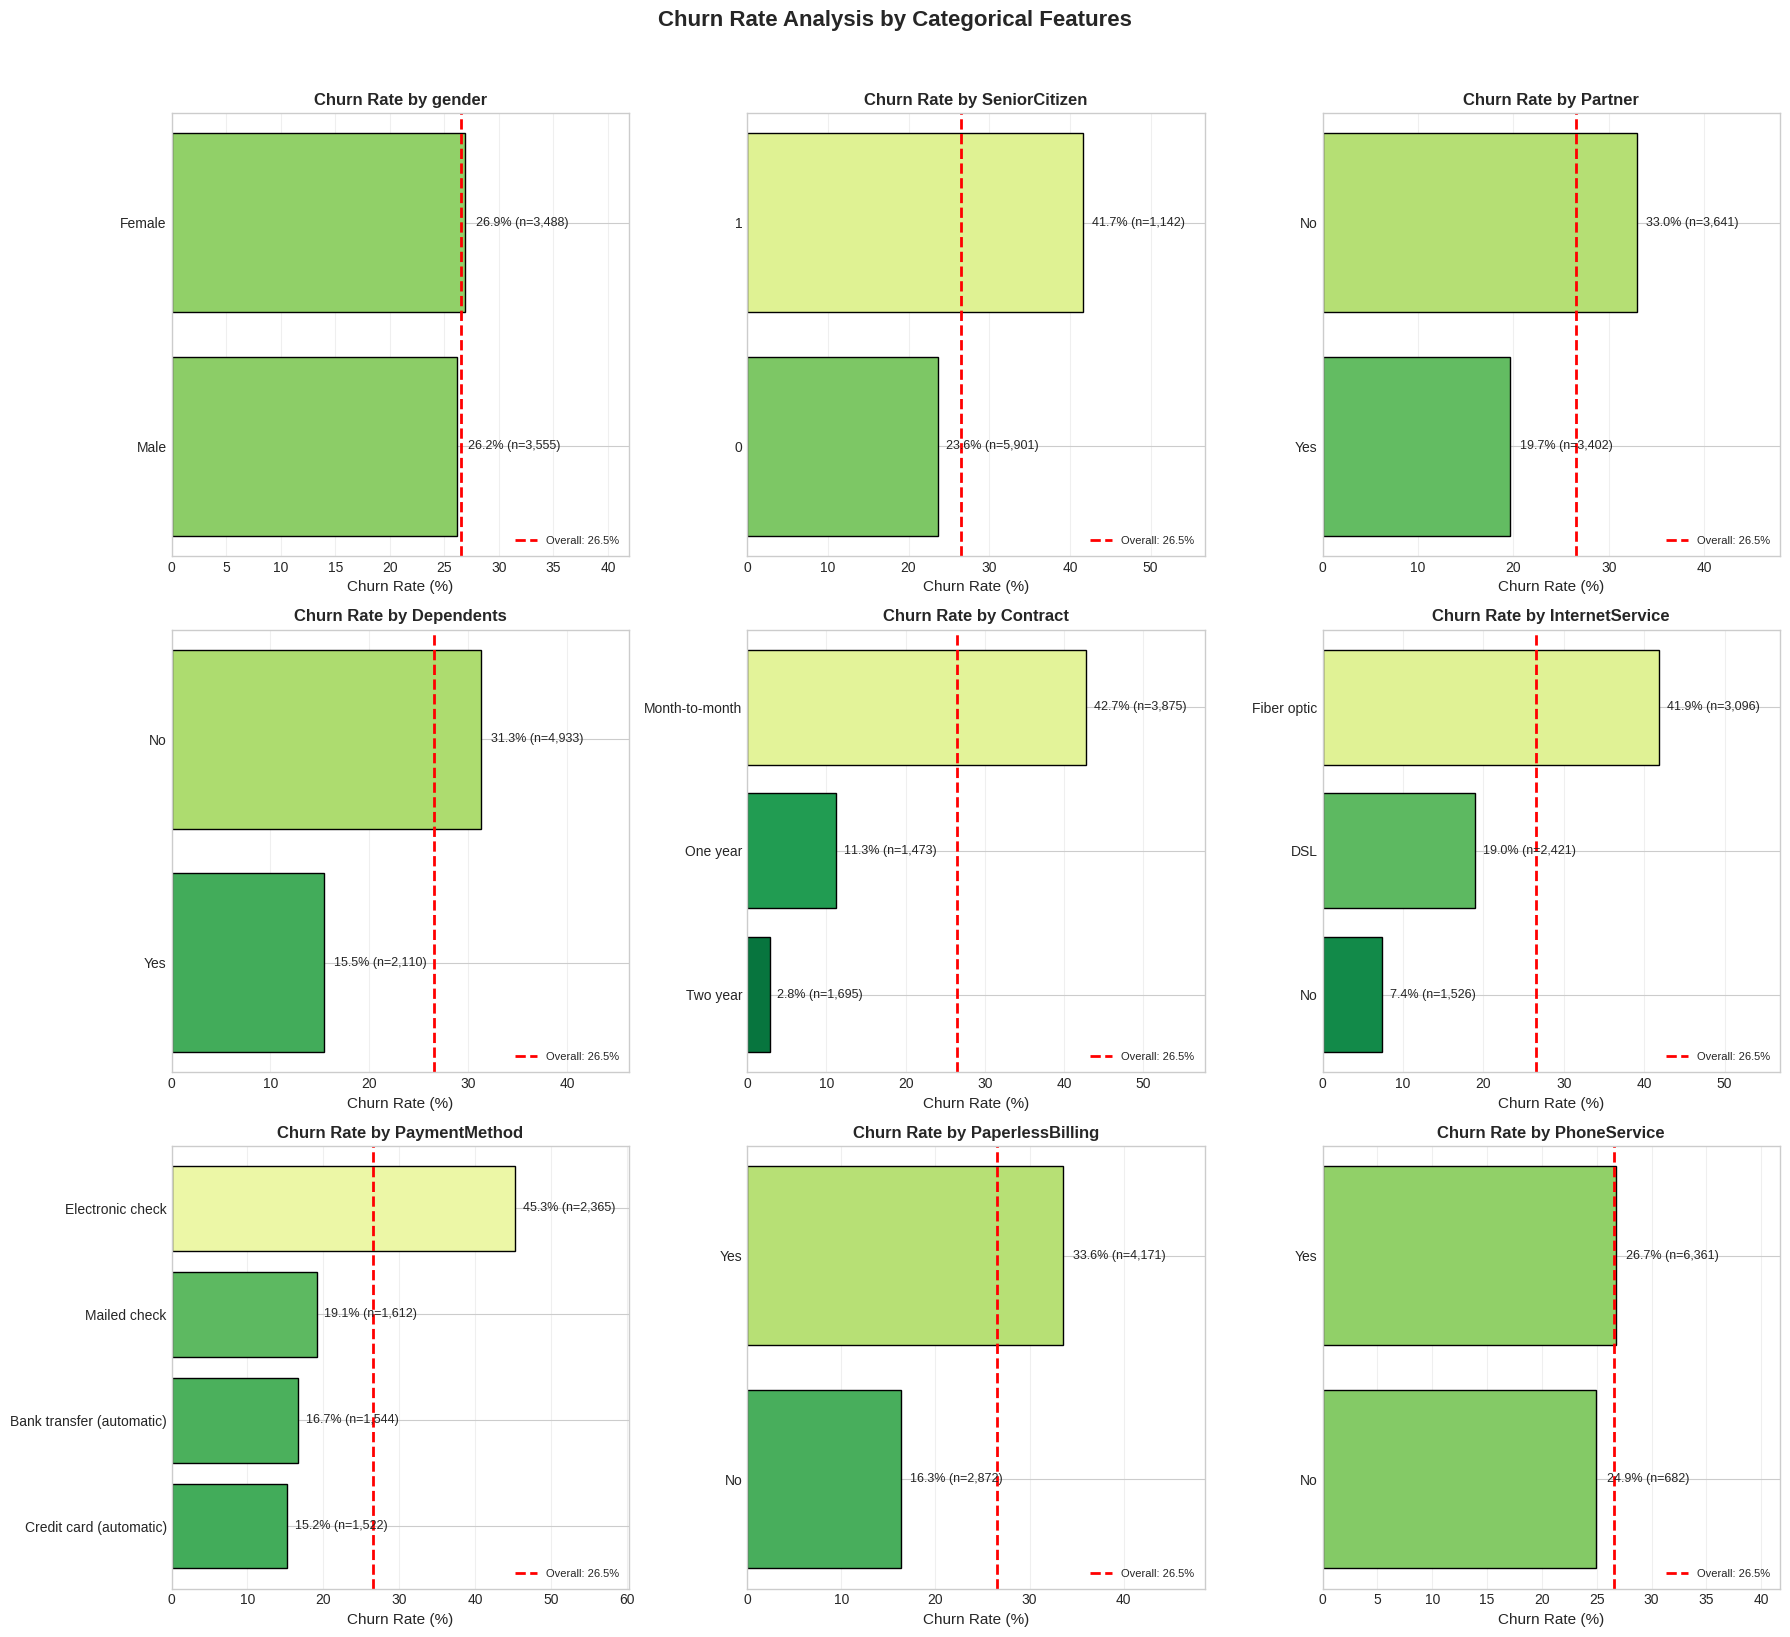


DETAILED CHURN RATE BY CATEGORY

Overall Churn Rate: 26.54%


GENDER:
--------------------------------------------------
  • Female: 26.92% (n=3,488) ↑ 0.38% vs overall
  • Male: 26.16% (n=3,555) ↓ 0.38% vs overall

SENIORCITIZEN:
--------------------------------------------------
  • 1: 41.68% (n=1,142) ↑ 15.14% vs overall
  • 0: 23.61% (n=5,901) ↓ 2.93% vs overall

PARTNER:
--------------------------------------------------
  • No: 32.96% (n=3,641) ↑ 6.42% vs overall
  • Yes: 19.66% (n=3,402) ↓ 6.87% vs overall

DEPENDENTS:
--------------------------------------------------
  • No: 31.28% (n=4,933) ↑ 4.74% vs overall
  • Yes: 15.45% (n=2,110) ↓ 11.09% vs overall

CONTRACT:
--------------------------------------------------
  • Month-to-month: 42.71% (n=3,875) ↑ 16.17% vs overall
  • One year: 11.27% (n=1,473) ↓ 15.27% vs overall
  • Two year: 2.83% (n=1,695) ↓ 23.71% vs overall

INTERNETSERVICE:
--------------------------------------------------
  • Fiber optic: 41.89% (n=3,096) ↑ 1

In [13]:
# ============================================================================
# DETAILED CHURN ANALYSIS BY EACH CATEGORICAL FEATURE
# ============================================================================

print("=" * 70)
print("CHURN RATE ANALYSIS BY CATEGORICAL FEATURES")
print("=" * 70)

# Create temporary churn column for analysis
data_temp = data.copy()
data_temp['Churn_Binary'] = data_temp['Churn'].map({'Yes': 1, 'No': 0})

categorical_for_churn = ['gender', 'SeniorCitizen', 'Partner', 'Dependents',
                         'Contract', 'InternetService', 'PaymentMethod',
                         'PaperlessBilling', 'PhoneService']

fig, axes = plt.subplots(3, 3, figsize=(18, 16))
axes = axes.flatten()

for idx, col in enumerate(categorical_for_churn):
    ax = axes[idx]

    # Calculate churn rate by category
    churn_by_cat = data_temp.groupby(col)['Churn_Binary'].agg(['mean', 'count'])
    churn_by_cat['churn_rate'] = churn_by_cat['mean'] * 100
    churn_by_cat = churn_by_cat.sort_values('churn_rate', ascending=True)

    # Create horizontal bar chart
    colors = plt.cm.RdYlGn_r(churn_by_cat['churn_rate'] / 100)
    bars = ax.barh(range(len(churn_by_cat)), churn_by_cat['churn_rate'], color=colors, edgecolor='black')

    # Add value labels
    for i, (bar, rate, count) in enumerate(zip(bars, churn_by_cat['churn_rate'], churn_by_cat['count'])):
        ax.text(bar.get_width() + 1, bar.get_y() + bar.get_height()/2,
                f'{rate:.1f}% (n={count:,})', va='center', fontsize=9)

    ax.set_yticks(range(len(churn_by_cat)))
    ax.set_yticklabels(churn_by_cat.index)
    ax.set_xlabel('Churn Rate (%)', fontsize=11)
    ax.set_title(f'Churn Rate by {col}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, max(churn_by_cat['churn_rate']) + 15)
    ax.axvline(x=data_temp['Churn_Binary'].mean() * 100, color='red', linestyle='--',
               linewidth=2, label=f'Overall: {data_temp["Churn_Binary"].mean()*100:.1f}%')
    ax.legend(loc='lower right', fontsize=8)
    ax.grid(True, alpha=0.3, axis='x')

plt.suptitle('Churn Rate Analysis by Categorical Features', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('churn_rate_by_categories_detailed.png', dpi=300, bbox_inches='tight')
plt.show()

# Print detailed churn analysis
print("\n" + "=" * 70)
print("DETAILED CHURN RATE BY CATEGORY")
print("=" * 70)

overall_churn = data_temp['Churn_Binary'].mean() * 100
print(f"\nOverall Churn Rate: {overall_churn:.2f}%\n")

for col in categorical_for_churn:
    print(f"\n{col.upper()}:")
    print("-" * 50)
    churn_by_cat = data_temp.groupby(col)['Churn_Binary'].agg(['mean', 'count'])
    churn_by_cat['churn_rate'] = churn_by_cat['mean'] * 100
    churn_by_cat = churn_by_cat.sort_values('churn_rate', ascending=False)

    for category in churn_by_cat.index:
        rate = churn_by_cat.loc[category, 'churn_rate']
        count = churn_by_cat.loc[category, 'count']
        diff = rate - overall_churn
        indicator = "↑" if diff > 0 else "↓"
        print(f"  • {category}: {rate:.2f}% (n={count:,}) {indicator} {abs(diff):.2f}% vs overall")

print("\n" + "=" * 70)
print("Churn rate analysis complete!")
print("=" * 70)

---
# Data Visualizations
---

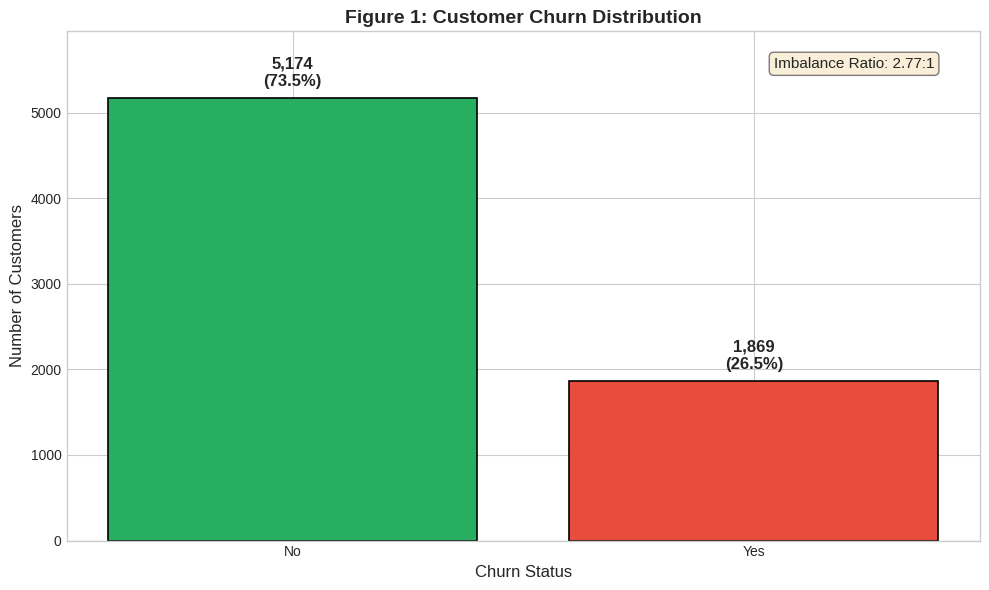

Figure 1 saved: fig1_churn_distribution.png


In [14]:
# Figure 1: Target Variable Distribution (Combined Bar + Annotation)
fig, ax = plt.subplots(figsize=(10, 6))

colors = ['#27ae60', '#e74c3c']  # Green for No, Red for Yes
bars = ax.bar(target_counts.index, target_counts.values, color=colors, edgecolor='black', linewidth=1.2)

# Add value labels on bars
for bar, count, pct in zip(bars, target_counts.values, target_pct.values):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 100,
            f'{count:,}\n({pct:.1f}%)',
            ha='center', va='bottom', fontsize=12, fontweight='bold')

ax.set_xlabel('Churn Status', fontsize=12)
ax.set_ylabel('Number of Customers', fontsize=12)
ax.set_title('Figure 1: Customer Churn Distribution', fontsize=14, fontweight='bold')
ax.set_ylim(0, max(target_counts.values) * 1.15)

# Add imbalance ratio annotation
ax.annotate(f'Imbalance Ratio: {imbalance_ratio:.2f}:1',
            xy=(0.95, 0.95), xycoords='axes fraction',
            fontsize=11, ha='right', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('fig1_churn_distribution.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 1 saved: fig1_churn_distribution.png")

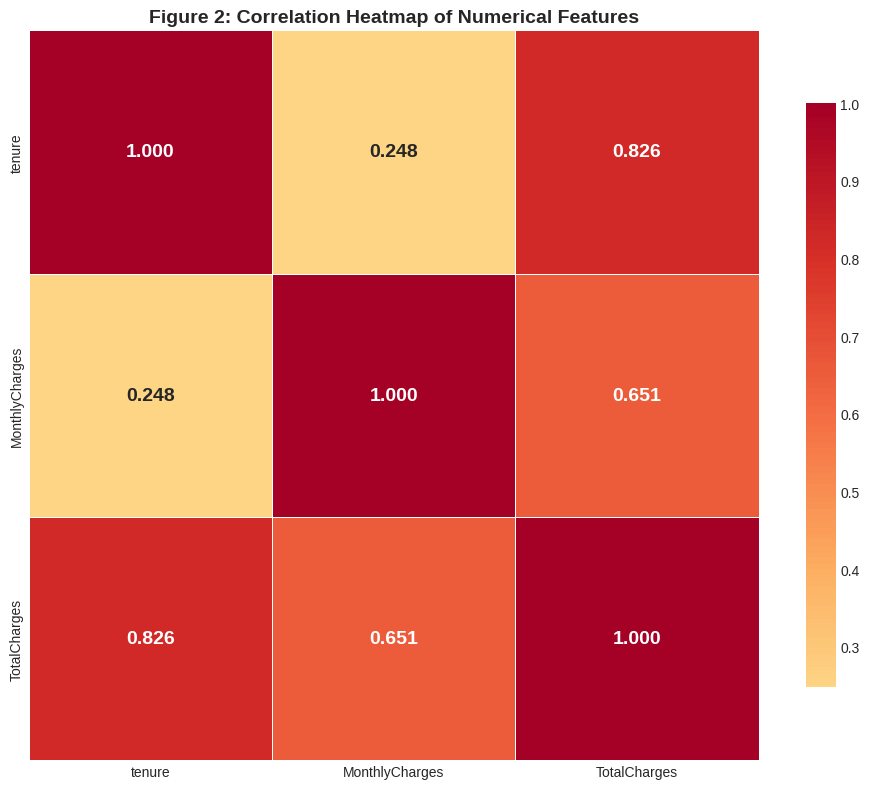

Figure 2 saved: fig2_correlation_heatmap.png

Key Correlations:
  Tenure - TotalCharges: 0.826 (Strong positive)
  Tenure - MonthlyCharges: 0.248
  MonthlyCharges - TotalCharges: 0.651


In [15]:
# Figure 2: Correlation Heatmap
plt.figure(figsize=(10, 8))

corr_matrix = data[numerical_cols].corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Upper triangle mask

sns.heatmap(corr_matrix, annot=True, cmap='RdYlBu_r', center=0, fmt='.3f',
            square=True, linewidths=0.5, annot_kws={'size': 14, 'weight': 'bold'},
            cbar_kws={'shrink': 0.8})

plt.title('Figure 2: Correlation Heatmap of Numerical Features', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig2_correlation_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print("Figure 2 saved: fig2_correlation_heatmap.png")
print(f"\nKey Correlations:")
print(f"  Tenure - TotalCharges: {corr_matrix.loc['tenure', 'TotalCharges']:.3f} (Strong positive)")
print(f"  Tenure - MonthlyCharges: {corr_matrix.loc['tenure', 'MonthlyCharges']:.3f}")
print(f"  MonthlyCharges - TotalCharges: {corr_matrix.loc['MonthlyCharges', 'TotalCharges']:.3f}")

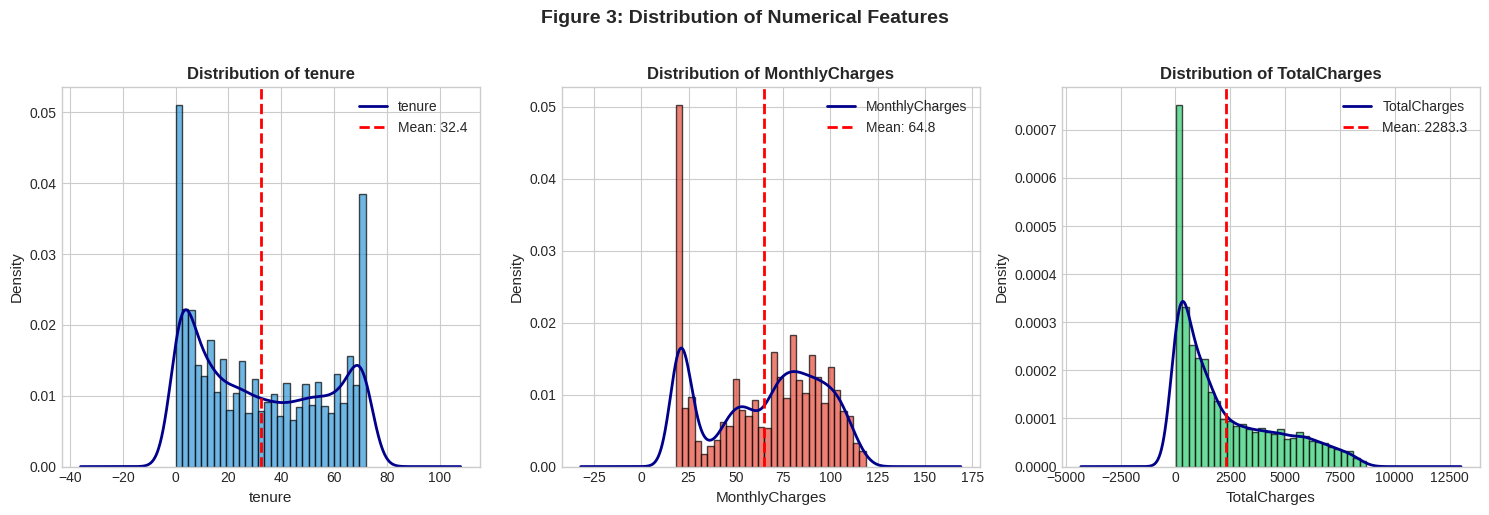

Figure 3 saved: fig3_numerical_distributions.png


In [16]:
# Figure 3: Distribution of Numerical Features (Histograms with KDE)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (col, ax, color) in enumerate(zip(numerical_cols, axes, colors)):
    # Histogram with KDE
    data[col].dropna().hist(bins=30, ax=ax, color=color, edgecolor='black', alpha=0.7, density=True)
    data[col].dropna().plot.kde(ax=ax, color='darkblue', linewidth=2)

    # Add mean line
    mean_val = data[col].mean()
    ax.axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_val:.1f}')

    ax.set_xlabel(col, fontsize=11)
    ax.set_ylabel('Density', fontsize=11)
    ax.set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    ax.legend(loc='upper right')

plt.suptitle('Figure 3: Distribution of Numerical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig3_numerical_distributions.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 3 saved: fig3_numerical_distributions.png")

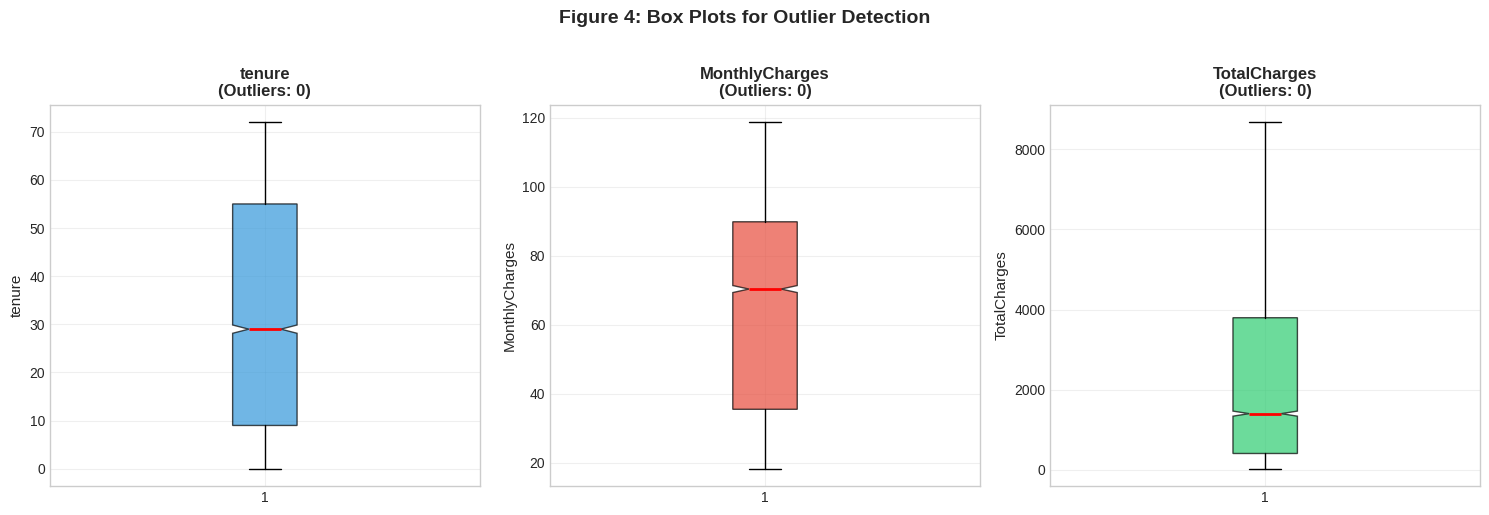

Figure 4 saved: fig4_boxplots.png


In [17]:
# Figure 4: Box Plots for Outlier Detection
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
colors = ['#3498db', '#e74c3c', '#2ecc71']

for i, (col, ax, color) in enumerate(zip(numerical_cols, axes, colors)):
    bp = ax.boxplot(data[col].dropna(), patch_artist=True, notch=True)
    bp['boxes'][0].set_facecolor(color)
    bp['boxes'][0].set_alpha(0.7)
    bp['medians'][0].set_color('red')
    bp['medians'][0].set_linewidth(2)

    # Calculate outliers
    Q1 = data[col].quantile(0.25)
    Q3 = data[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = data[(data[col] < Q1 - 1.5*IQR) | (data[col] > Q3 + 1.5*IQR)][col]

    ax.set_ylabel(col, fontsize=11)
    ax.set_title(f'{col}\n(Outliers: {len(outliers)})', fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.suptitle('Figure 4: Box Plots for Outlier Detection', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig4_boxplots.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 4 saved: fig4_boxplots.png")

NUMERICAL FEATURES COMPARISON: CHURNED vs NON-CHURNED CUSTOMERS


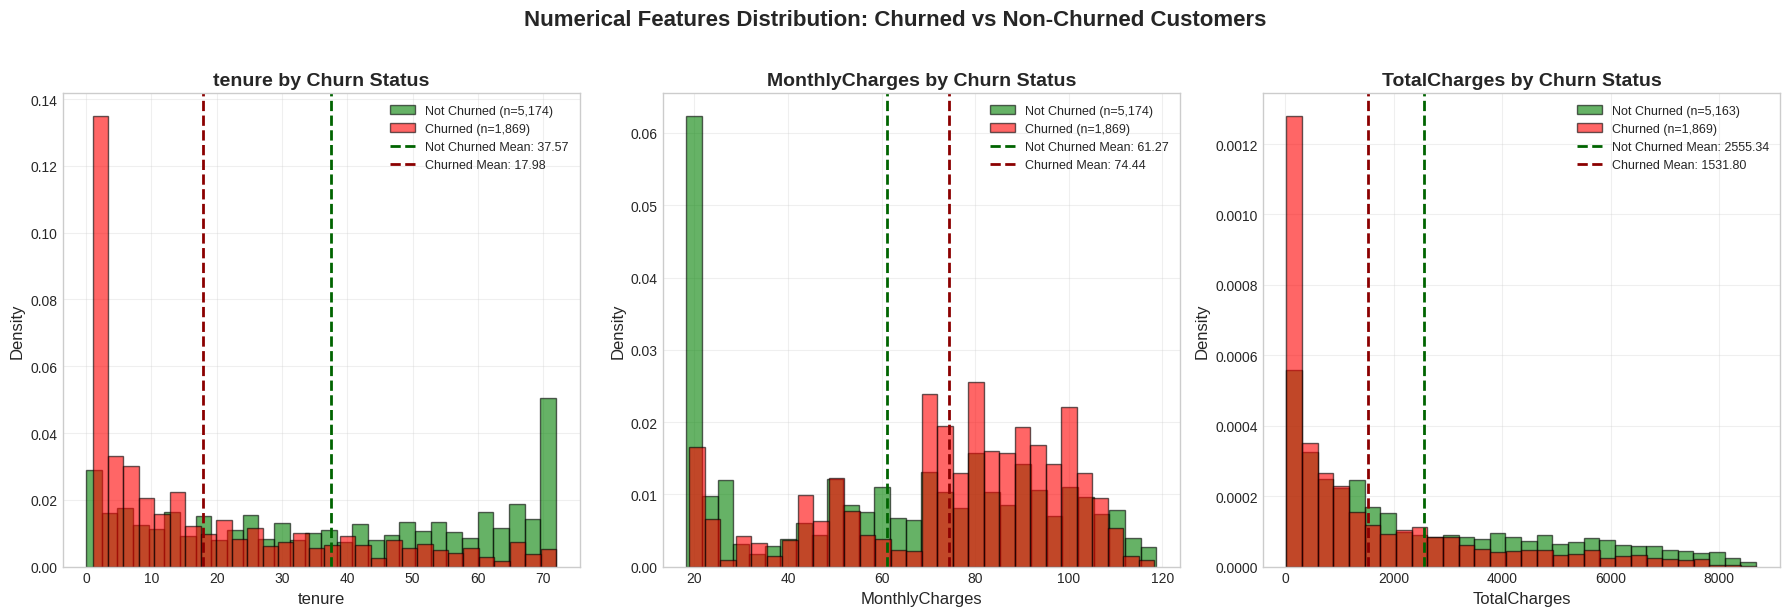


STATISTICAL COMPARISON: CHURNED vs NON-CHURNED

TENURE:
--------------------------------------------------
  Not Churned - Mean: 37.57, Median: 38.00, Std: 24.11
  Churned     - Mean: 17.98, Median: 10.00, Std: 19.53
  Difference  - Mean: 19.59
  T-test: t=31.580, p-value=8.00e-205 (Statistically significant difference)

MONTHLYCHARGES:
--------------------------------------------------
  Not Churned - Mean: 61.27, Median: 64.43, Std: 31.09
  Churned     - Mean: 74.44, Median: 79.65, Std: 24.67
  Difference  - Mean: -13.18
  T-test: t=-16.537, p-value=2.71e-60 (Statistically significant difference)

TOTALCHARGES:
--------------------------------------------------
  Not Churned - Mean: 2555.34, Median: 1683.60, Std: 2329.46
  Churned     - Mean: 1531.80, Median: 703.55, Std: 1890.82
  Difference  - Mean: 1023.55
  T-test: t=17.069, p-value=4.88e-64 (Statistically significant difference)

Statistical comparison complete!


In [18]:
# ============================================================================
# NUMERICAL FEATURES VS CHURN - DETAILED COMPARISON
# ============================================================================

print("=" * 70)
print("NUMERICAL FEATURES COMPARISON: CHURNED vs NON-CHURNED CUSTOMERS")
print("=" * 70)

# Prepare data
data_comp = data.copy()
data_comp['TotalCharges'] = pd.to_numeric(data_comp['TotalCharges'], errors='coerce')

numerical_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for idx, col in enumerate(numerical_cols):
    ax = axes[idx]

    # Separate data by churn status
    churned = data_comp[data_comp['Churn'] == 'Yes'][col].dropna()
    not_churned = data_comp[data_comp['Churn'] == 'No'][col].dropna()

    # Create overlapping histograms
    ax.hist(not_churned, bins=30, alpha=0.6, label=f'Not Churned (n={len(not_churned):,})',
            color='green', edgecolor='black', density=True)
    ax.hist(churned, bins=30, alpha=0.6, label=f'Churned (n={len(churned):,})',
            color='red', edgecolor='black', density=True)

    # Add mean lines
    ax.axvline(not_churned.mean(), color='darkgreen', linestyle='--', linewidth=2,
               label=f'Not Churned Mean: {not_churned.mean():.2f}')
    ax.axvline(churned.mean(), color='darkred', linestyle='--', linewidth=2,
               label=f'Churned Mean: {churned.mean():.2f}')

    ax.set_xlabel(col, fontsize=12)
    ax.set_ylabel('Density', fontsize=12)
    ax.set_title(f'{col} by Churn Status', fontsize=14, fontweight='bold')
    ax.legend(loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.suptitle('Numerical Features Distribution: Churned vs Non-Churned Customers',
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('numerical_features_churn_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Statistical comparison
print("\n" + "=" * 70)
print("STATISTICAL COMPARISON: CHURNED vs NON-CHURNED")
print("=" * 70)

for col in numerical_cols:
    churned = data_comp[data_comp['Churn'] == 'Yes'][col].dropna()
    not_churned = data_comp[data_comp['Churn'] == 'No'][col].dropna()

    print(f"\n{col.upper()}:")
    print("-" * 50)
    print(f"  Not Churned - Mean: {not_churned.mean():.2f}, Median: {not_churned.median():.2f}, Std: {not_churned.std():.2f}")
    print(f"  Churned     - Mean: {churned.mean():.2f}, Median: {churned.median():.2f}, Std: {churned.std():.2f}")
    print(f"  Difference  - Mean: {not_churned.mean() - churned.mean():.2f}")

    # T-test
    t_stat, p_value = stats.ttest_ind(not_churned, churned)
    print(f"  T-test: t={t_stat:.3f}, p-value={p_value:.2e}", end=" ")
    if p_value < 0.05:
        print("(Statistically significant difference)")
    else:
        print("(Not statistically significant)")

print("\n" + "=" * 70)
print("Statistical comparison complete!")
print("=" * 70)

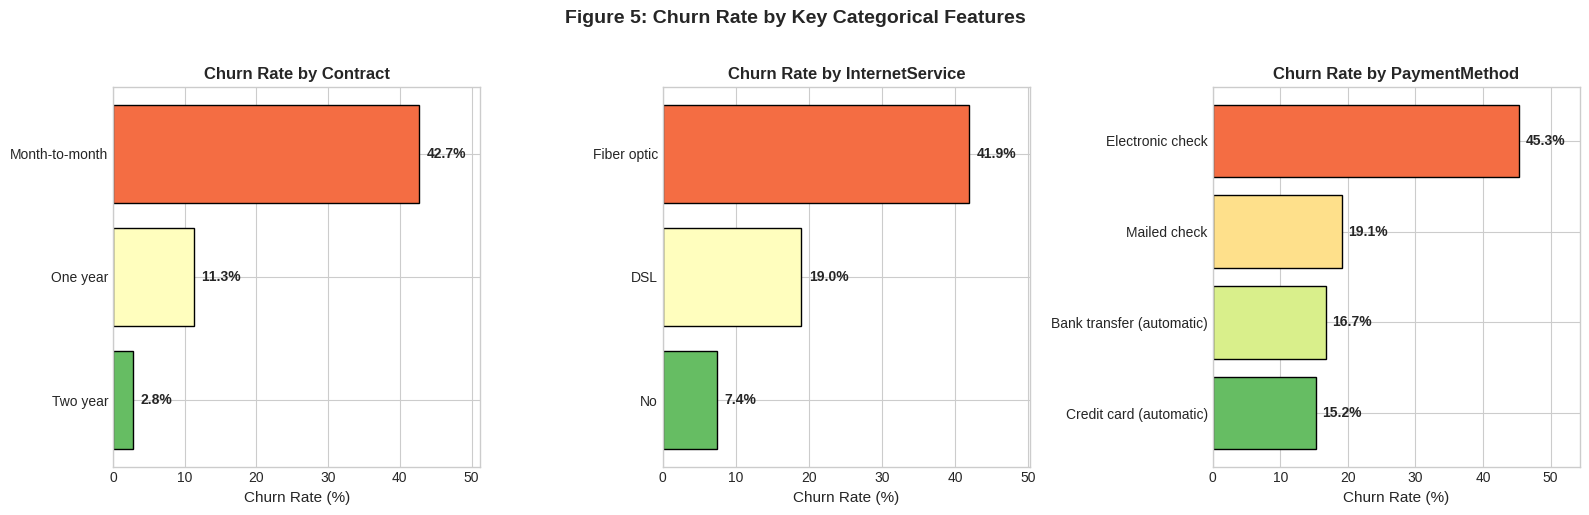

Figure 5 saved: fig5_churn_by_categories.png


In [19]:
# Figure 5: Churn Rate by Contract Type, Internet Service, and Payment Method
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

analysis_cols = ['Contract', 'InternetService', 'PaymentMethod']

for ax, col in zip(axes, analysis_cols):
    # Calculate churn rate per category
    churn_rate = data.groupby(col)['Churn'].apply(lambda x: (x == 'Yes').mean() * 100)
    churn_rate = churn_rate.sort_values(ascending=True)

    colors = plt.cm.RdYlGn_r(np.linspace(0.2, 0.8, len(churn_rate)))
    bars = ax.barh(churn_rate.index, churn_rate.values, color=colors, edgecolor='black')

    # Add value labels
    for bar, val in zip(bars, churn_rate.values):
        ax.text(val + 1, bar.get_y() + bar.get_height()/2, f'{val:.1f}%',
                va='center', fontsize=10, fontweight='bold')

    ax.set_xlabel('Churn Rate (%)', fontsize=11)
    ax.set_title(f'Churn Rate by {col}', fontsize=12, fontweight='bold')
    ax.set_xlim(0, max(churn_rate.values) * 1.2)

plt.suptitle('Figure 5: Churn Rate by Key Categorical Features', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig5_churn_by_categories.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 5 saved: fig5_churn_by_categories.png")

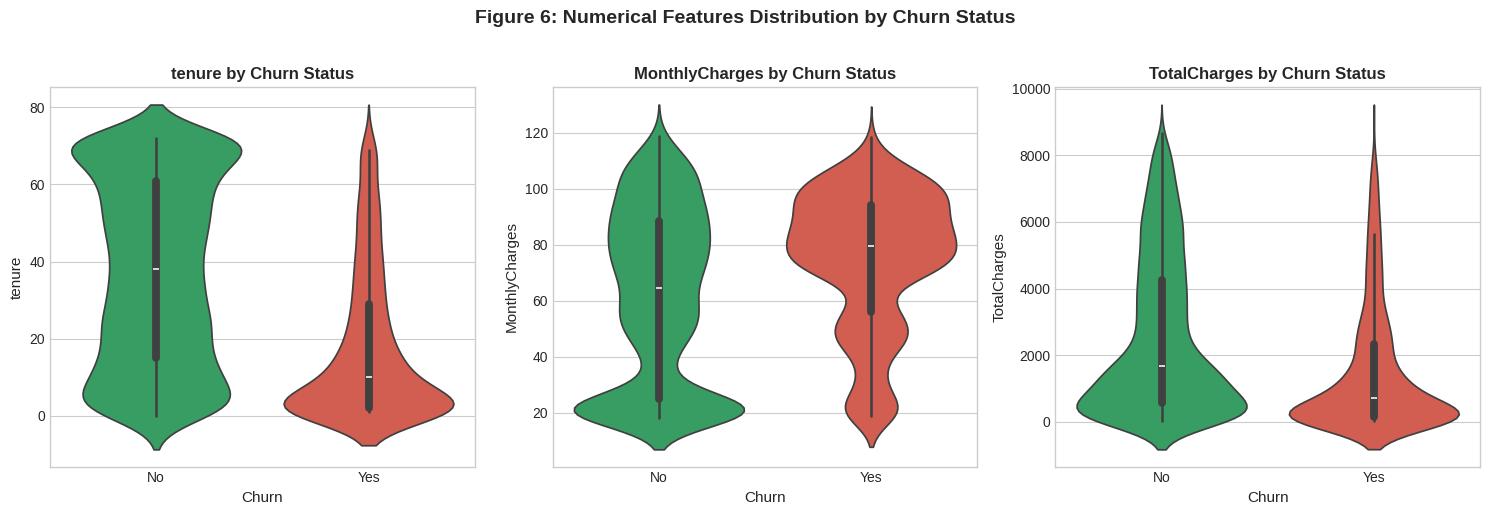

Figure 6 saved: fig6_violin_plots.png


In [20]:
# Figure 6: Numerical Features vs Churn (Violin Plots)
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

for i, (col, ax) in enumerate(zip(numerical_cols, axes)):
    sns.violinplot(x='Churn', y=col, data=data, ax=ax, palette=['#27ae60', '#e74c3c'])
    ax.set_xlabel('Churn', fontsize=11)
    ax.set_ylabel(col, fontsize=11)
    ax.set_title(f'{col} by Churn Status', fontsize=12, fontweight='bold')

plt.suptitle('Figure 6: Numerical Features Distribution by Churn Status', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig6_violin_plots.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 6 saved: fig6_violin_plots.png")

---
# TASK 2A: Corpus Preparation
---

In [21]:
# Reload fresh data for preprocessing
data = df.copy()

print("=" * 70)
print("CORPUS PREPARATION PIPELINE")
print("=" * 70)
print(f"\nInitial dataset shape: {data.shape}")

CORPUS PREPARATION PIPELINE

Initial dataset shape: (7043, 21)


In [22]:
# Step 1: Convert TotalCharges to numeric
print("\n" + "-" * 50)
print("Step 1: Convert TotalCharges to Numeric")
print("-" * 50)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
print(f"Missing values revealed: {data['TotalCharges'].isnull().sum()}")

# Step 2: Impute missing values with median
print("\n" + "-" * 50)
print("Step 2: Impute Missing Values (Median)")
print("-" * 50)
median_val = data['TotalCharges'].median()
data['TotalCharges'].fillna(median_val, inplace=True)
print(f"Median used for imputation: ${median_val:.2f}")
print(f"Missing values after imputation: {data['TotalCharges'].isnull().sum()}")

# Step 3: Remove customerID
print("\n" + "-" * 50)
print("Step 3: Remove customerID (Non-predictive)")
print("-" * 50)
data.drop(columns=['customerID'], inplace=True)
print(f"customerID removed. New shape: {data.shape}")


--------------------------------------------------
Step 1: Convert TotalCharges to Numeric
--------------------------------------------------
Missing values revealed: 11

--------------------------------------------------
Step 2: Impute Missing Values (Median)
--------------------------------------------------
Median used for imputation: $1397.47
Missing values after imputation: 0

--------------------------------------------------
Step 3: Remove customerID (Non-predictive)
--------------------------------------------------
customerID removed. New shape: (7043, 20)


In [23]:
# Step 4: Binary Encoding
print("\n" + "-" * 50)
print("Step 4: Binary Encoding")
print("-" * 50)

binary_maps = {
    'gender': {'Male': 1, 'Female': 0},
    'Partner': {'Yes': 1, 'No': 0},
    'Dependents': {'Yes': 1, 'No': 0},
    'PhoneService': {'Yes': 1, 'No': 0},
    'PaperlessBilling': {'Yes': 1, 'No': 0},
    'Churn': {'Yes': 1, 'No': 0}
}

for col, mapping in binary_maps.items():
    data[col] = data[col].map(mapping)
    print(f"  {col}: {mapping}")

# Step 5: One-Hot Encoding
print("\n" + "-" * 50)
print("Step 5: One-Hot Encoding")
print("-" * 50)

onehot_cols = ['MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
               'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies',
               'Contract', 'PaymentMethod']

print(f"Columns before encoding: {len(data.columns)}")
data = pd.get_dummies(data, columns=onehot_cols, drop_first=True)
print(f"Columns after encoding: {len(data.columns)}")
print(f"New columns created: {len(data.columns) - 10}")


--------------------------------------------------
Step 4: Binary Encoding
--------------------------------------------------
  gender: {'Male': 1, 'Female': 0}
  Partner: {'Yes': 1, 'No': 0}
  Dependents: {'Yes': 1, 'No': 0}
  PhoneService: {'Yes': 1, 'No': 0}
  PaperlessBilling: {'Yes': 1, 'No': 0}
  Churn: {'Yes': 1, 'No': 0}

--------------------------------------------------
Step 5: One-Hot Encoding
--------------------------------------------------
Columns before encoding: 20
Columns after encoding: 31
New columns created: 21


In [24]:
# Step 6: Outlier Removal
print("\n" + "-" * 50)
print("Step 6: Outlier Removal (Z-score > 3)")
print("-" * 50)

numerical_features = ['tenure', 'MonthlyCharges', 'TotalCharges']
print(f"Rows before outlier removal: {len(data)}")

z_scores = np.abs(zscore(data[numerical_features]))
outlier_mask = (z_scores < 3).all(axis=1)
outliers_removed = len(data) - outlier_mask.sum()
data = data[outlier_mask]

print(f"Rows after outlier removal: {len(data)}")
print(f"Outliers removed: {outliers_removed} ({(outliers_removed/len(df))*100:.2f}%)")


--------------------------------------------------
Step 6: Outlier Removal (Z-score > 3)
--------------------------------------------------
Rows before outlier removal: 7043
Rows after outlier removal: 7043
Outliers removed: 0 (0.00%)


In [25]:
# Step 7: Feature Scaling
print("\n" + "-" * 50)
print("Step 7: Feature Scaling (StandardScaler)")
print("-" * 50)

X = data.drop(columns=['Churn'])
y = data['Churn']

scaler = StandardScaler()
X[numerical_features] = scaler.fit_transform(X[numerical_features])

print("Numerical features scaled to mean=0, std=1")
print(f"\nScaled feature statistics:")
for col in numerical_features:
    print(f"  {col}: mean={X[col].mean():.4f}, std={X[col].std():.4f}")


--------------------------------------------------
Step 7: Feature Scaling (StandardScaler)
--------------------------------------------------
Numerical features scaled to mean=0, std=1

Scaled feature statistics:
  tenure: mean=-0.0000, std=1.0001
  MonthlyCharges: mean=-0.0000, std=1.0001
  TotalCharges: mean=-0.0000, std=1.0001


In [26]:
# Step 8: SMOTE for Class Balancing
print("\n" + "-" * 50)
print("Step 8: SMOTE for Class Balancing")
print("-" * 50)

print(f"Class distribution BEFORE SMOTE: {Counter(y)}")

smote = SMOTE(random_state=42, k_neighbors=5)
X_balanced, y_balanced = smote.fit_resample(X, y)

print(f"Class distribution AFTER SMOTE: {Counter(y_balanced)}")
print(f"\nSamples added: {len(y_balanced) - len(y)}")


--------------------------------------------------
Step 8: SMOTE for Class Balancing
--------------------------------------------------
Class distribution BEFORE SMOTE: Counter({0: 5174, 1: 1869})
Class distribution AFTER SMOTE: Counter({0: 5174, 1: 5174})

Samples added: 3305


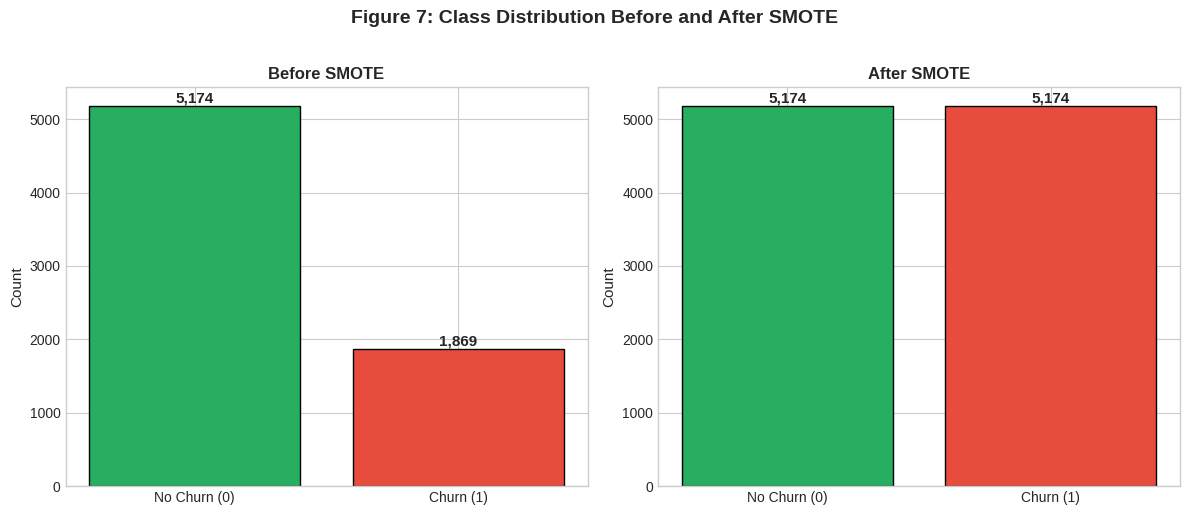

Figure 7 saved: fig7_smote_comparison.png


In [27]:
# Figure 7: Class Distribution Before and After SMOTE
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Before SMOTE
before_counts = pd.Series(y).value_counts().sort_index()
bars1 = axes[0].bar(['No Churn (0)', 'Churn (1)'], before_counts.values,
                    color=['#27ae60', '#e74c3c'], edgecolor='black')
axes[0].set_title('Before SMOTE', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=11)
for bar, val in zip(bars1, before_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{val:,}', ha='center', fontsize=11, fontweight='bold')

# After SMOTE
after_counts = pd.Series(y_balanced).value_counts().sort_index()
bars2 = axes[1].bar(['No Churn (0)', 'Churn (1)'], after_counts.values,
                    color=['#27ae60', '#e74c3c'], edgecolor='black')
axes[1].set_title('After SMOTE', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=11)
for bar, val in zip(bars2, after_counts.values):
    axes[1].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 50,
                 f'{val:,}', ha='center', fontsize=11, fontweight='bold')

plt.suptitle('Figure 7: Class Distribution Before and After SMOTE', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig7_smote_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 7 saved: fig7_smote_comparison.png")

In [28]:
# Step 9: Train-Test Split
print("\n" + "-" * 50)
print("Step 9: Train-Test Split (80-20, Stratified)")
print("-" * 50)

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced,
    test_size=0.20,
    random_state=42,
    stratify=y_balanced
)

print(f"Training set: X_train={X_train.shape}, y_train={y_train.shape}")
print(f"Testing set:  X_test={X_test.shape}, y_test={y_test.shape}")
print(f"\nTrain set class distribution: {Counter(y_train)}")
print(f"Test set class distribution: {Counter(y_test)}")

print("\n" + "=" * 70)
print("CORPUS PREPARATION COMPLETE!")
print("=" * 70)
print(f"\nFinal feature count: {X_train.shape[1]}")
print(f"Total samples for training: {len(y_train):,}")
print(f"Total samples for testing: {len(y_test):,}")


--------------------------------------------------
Step 9: Train-Test Split (80-20, Stratified)
--------------------------------------------------
Training set: X_train=(8278, 30), y_train=(8278,)
Testing set:  X_test=(2070, 30), y_test=(2070,)

Train set class distribution: Counter({1: 4139, 0: 4139})
Test set class distribution: Counter({0: 1035, 1: 1035})

CORPUS PREPARATION COMPLETE!

Final feature count: 30
Total samples for training: 8,278
Total samples for testing: 2,070


---
# TASK 2B: Model Implementation
---

## Model 1: Decision Tree Classifier with GridSearchCV

In [29]:
# Decision Tree with GridSearchCV
print("=" * 70)
print("DECISION TREE CLASSIFIER WITH GRIDSEARCHCV")
print("=" * 70)

# Define hyperparameter grid
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [5, 10, 15, 20, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

total_combinations = 2 * 5 * 3 * 3 * 3
print(f"\nHyperparameter Grid:")
for param, values in param_grid.items():
    print(f"  {param}: {values}")
print(f"\nTotal parameter combinations: {total_combinations}")
print(f"With 5-fold CV: {total_combinations * 5} fits")

print("\nRunning GridSearchCV ")

DECISION TREE CLASSIFIER WITH GRIDSEARCHCV

Hyperparameter Grid:
  criterion: ['gini', 'entropy']
  max_depth: [5, 10, 15, 20, None]
  min_samples_split: [2, 5, 10]
  min_samples_leaf: [1, 2, 4]
  max_features: ['sqrt', 'log2', None]

Total parameter combinations: 270
With 5-fold CV: 1350 fits

Running GridSearchCV 


In [30]:
# Execute GridSearchCV
dt = DecisionTreeClassifier(random_state=42)
grid_search = GridSearchCV(
    dt, param_grid,
    cv=5,
    scoring='f1',
    n_jobs=-1,
    verbose=1,
    return_train_score=True
)
grid_search.fit(X_train, y_train)

print("\n" + "-" * 50)
print("Best Parameters Found:")
print("-" * 50)
for param, val in grid_search.best_params_.items():
    print(f"  {param}: {val}")
print(f"\nBest Cross-Validation F1-Score: {grid_search.best_score_:.4f}")

Fitting 5 folds for each of 270 candidates, totalling 1350 fits

--------------------------------------------------
Best Parameters Found:
--------------------------------------------------
  criterion: gini
  max_depth: 10
  max_features: None
  min_samples_leaf: 1
  min_samples_split: 5

Best Cross-Validation F1-Score: 0.7967


In [31]:
# Decision Tree Evaluation with Overfitting Check
best_dt = grid_search.best_estimator_

# Predictions
dt_train_pred = best_dt.predict(X_train)
dt_test_pred = best_dt.predict(X_test)
dt_train_proba = best_dt.predict_proba(X_train)[:, 1]
dt_test_proba = best_dt.predict_proba(X_test)[:, 1]

# Calculate metrics for both train and test
dt_train_accuracy = accuracy_score(y_train, dt_train_pred)
dt_test_accuracy = accuracy_score(y_test, dt_test_pred)
dt_train_f1 = f1_score(y_train, dt_train_pred)
dt_test_f1 = f1_score(y_test, dt_test_pred)
dt_train_auc = roc_auc_score(y_train, dt_train_proba)
dt_test_auc = roc_auc_score(y_test, dt_test_proba)

# Store test metrics
dt_accuracy = dt_test_accuracy
dt_precision = precision_score(y_test, dt_test_pred)
dt_recall = recall_score(y_test, dt_test_pred)
dt_f1 = dt_test_f1
dt_roc_auc = dt_test_auc

print("=" * 70)
print("DECISION TREE EVALUATION RESULTS")
print("=" * 70)

print("\n--- Training vs Test Performance (Overfitting Check) ---")
print(f"{'Metric':<15} {'Training':<12} {'Test':<12} {'Gap':<10}")
print("-" * 50)
print(f"{'Accuracy':<15} {dt_train_accuracy:<12.4f} {dt_test_accuracy:<12.4f} {dt_train_accuracy - dt_test_accuracy:<10.4f}")
print(f"{'F1-Score':<15} {dt_train_f1:<12.4f} {dt_test_f1:<12.4f} {dt_train_f1 - dt_test_f1:<10.4f}")
print(f"{'ROC-AUC':<15} {dt_train_auc:<12.4f} {dt_test_auc:<12.4f} {dt_train_auc - dt_test_auc:<10.4f}")

# Overfitting warning
if (dt_train_accuracy - dt_test_accuracy) > 0.1:
    print("\nWARNING: Potential overfitting detected (Accuracy gap > 10%)")
elif (dt_train_auc - dt_test_auc) > 0.1:
    print("\nWARNING: Potential overfitting detected (AUC gap > 10%)")
else:
    print("\nNo significant overfitting detected")

print("\n--- Test Set Metrics ---")
print(f"  Accuracy:  {dt_accuracy:.4f}")
print(f"  Precision: {dt_precision:.4f}")
print(f"  Recall:    {dt_recall:.4f}")
print(f"  F1-Score:  {dt_f1:.4f}")
print(f"  ROC-AUC:   {dt_roc_auc:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, dt_test_pred, target_names=['No Churn', 'Churn']))

DECISION TREE EVALUATION RESULTS

--- Training vs Test Performance (Overfitting Check) ---
Metric          Training     Test         Gap       
--------------------------------------------------
Accuracy        0.8625       0.7850       0.0775    
F1-Score        0.8672       0.7941       0.0732    
ROC-AUC         0.9353       0.8434       0.0919    

No significant overfitting detected

--- Test Set Metrics ---
  Accuracy:  0.7850
  Precision: 0.7620
  Recall:    0.8290
  F1-Score:  0.7941
  ROC-AUC:   0.8434

--- Classification Report ---
              precision    recall  f1-score   support

    No Churn       0.81      0.74      0.78      1035
       Churn       0.76      0.83      0.79      1035

    accuracy                           0.79      2070
   macro avg       0.79      0.79      0.78      2070
weighted avg       0.79      0.79      0.78      2070



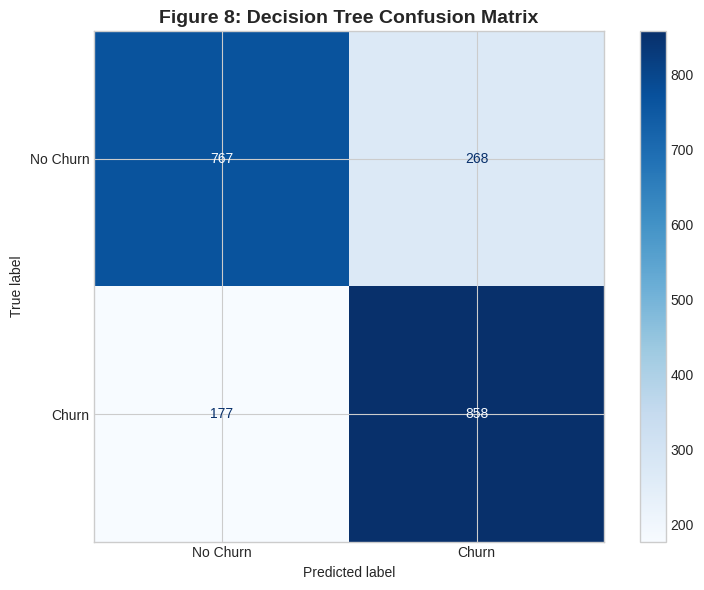

Figure 8 saved: fig8_dt_confusion_matrix.png

Confusion Matrix Breakdown:
  True Negatives (TN): 767
  False Positives (FP): 268
  False Negatives (FN): 177
  True Positives (TP): 858


In [32]:
# Figure 8: Decision Tree Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))

cm_dt = confusion_matrix(y_test, dt_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_dt, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Blues', ax=ax, values_format='d')

plt.title('Figure 8: Decision Tree Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig8_dt_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm_dt.ravel()
print(f"Figure 8 saved: fig8_dt_confusion_matrix.png")
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN): {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP): {tp}")

--- Top 10 Feature Importances ---


,Feature,Importance
26,Contract_Two year,0.247936
4,tenure,0.153489
25,Contract_One year,0.145769
7,MonthlyCharges,0.095207
11,InternetService_Fiber optic,0.085784
8,TotalCharges,0.055982
24,StreamingMovies_Yes,0.034824
28,PaymentMethod_Electronic check,0.033828
22,StreamingTV_Yes,0.018796
10,MultipleLines_Yes,0.017134


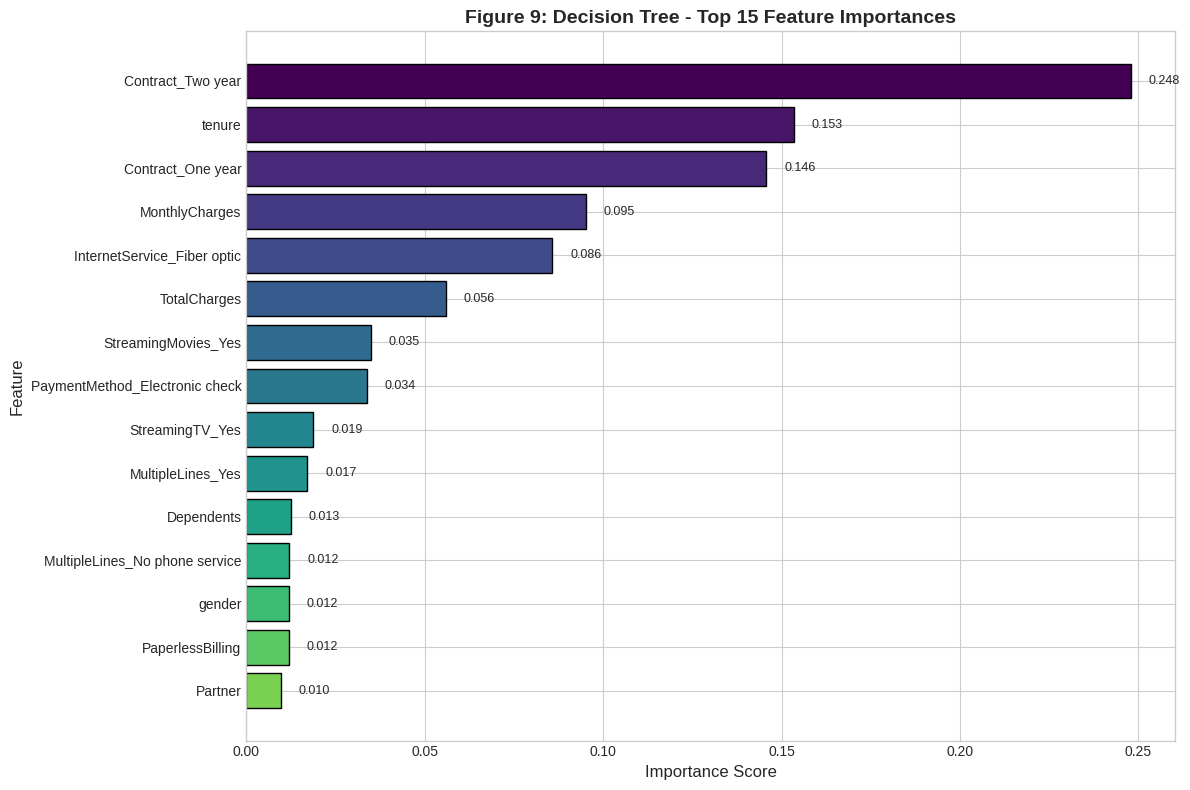

Figure 9 saved: fig9_dt_feature_importance.png


In [33]:
# Figure 9: Decision Tree Feature Importance
feat_imp = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': best_dt.feature_importances_
}).sort_values('Importance', ascending=False)

print("--- Top 10 Feature Importances ---")
display(feat_imp.head(10))

# Plot
plt.figure(figsize=(12, 8))
top15 = feat_imp.head(15)
colors = plt.cm.viridis(np.linspace(0, 0.8, 15))
bars = plt.barh(top15['Feature'], top15['Importance'], color=colors, edgecolor='black')

plt.xlabel('Importance Score', fontsize=12)
plt.ylabel('Feature', fontsize=12)
plt.title('Figure 9: Decision Tree - Top 15 Feature Importances', fontsize=14, fontweight='bold')
plt.gca().invert_yaxis()

# Add value labels
for bar, val in zip(bars, top15['Importance']):
    plt.text(val + 0.005, bar.get_y() + bar.get_height()/2,
             f'{val:.3f}', va='center', fontsize=9)

plt.tight_layout()
plt.savefig('fig9_dt_feature_importance.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 9 saved: fig9_dt_feature_importance.png")

## Model 2: Neural Network

In [34]:
# Neural Network Model Architecture
print("=" * 70)
print("NEURAL NETWORK MODEL")
print("=" * 70)

print("\nArchitecture Design:")
print("  Input Layer:  {} neurons".format(X_train.shape[1]))
print("  Hidden 1:     128 neurons (ReLU) + Dropout(0.3)")
print("  Hidden 2:     64 neurons (ReLU) + Dropout(0.3)")
print("  Hidden 3:     32 neurons (ReLU) + Dropout(0.2)")
print("  Hidden 4:     16 neurons (ReLU)")
print("  Output:       1 neuron (Sigmoid)")
print("\nOptimizer: Adam (lr=0.001)")
print("Loss: Binary Crossentropy")

nn_model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dense(1, activation='sigmoid')
])

nn_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

print("\n--- Model Summary ---")
nn_model.summary()

NEURAL NETWORK MODEL

Architecture Design:
  Input Layer:  30 neurons
  Hidden 1:     128 neurons (ReLU) + Dropout(0.3)
  Hidden 2:     64 neurons (ReLU) + Dropout(0.3)
  Hidden 3:     32 neurons (ReLU) + Dropout(0.2)
  Hidden 4:     16 neurons (ReLU)
  Output:       1 neuron (Sigmoid)

Optimizer: Adam (lr=0.001)
Loss: Binary Crossentropy

--- Model Summary ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         3,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,849 (58.00 KB)

 Trainable params: 14,849 (58.00 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
# Train Neural Network with Early Stopping
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

print("\nTraining Neural Network...")
print("(Early stopping enabled: patience=10)\n")

history = nn_model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

print("\nTraining complete!")


Training Neural Network...
(Early stopping enabled: patience=10)

Epoch 1/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.7057 - loss: 0.5828 - val_accuracy: 0.7699 - val_loss: 0.4902
Epoch 2/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.7654 - loss: 0.4989 - val_accuracy: 0.7717 - val_loss: 0.4869
Epoch 3/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7679 - loss: 0.4879 - val_accuracy: 0.7723 - val_loss: 0.4848
Epoch 4/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7724 - loss: 0.4763 - val_accuracy: 0.7723 - val_loss: 0.4811
Epoch 5/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7816 - loss: 0.4724 - val_accuracy: 0.7736 - val_loss: 0.4829
Epoch 6/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7836 - loss: 0.4667 - val_accuracy: 0.7699 - val_loss: 0.4818
Epoch 7/100
207/207 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.7828 - loss: 0.4665 - val_accuracy: 0.7663 - val_loss: 0.4779
Epoch 8/100
207/207 ━━━━━━━━━━

In [36]:
# Neural Network Evaluation with Overfitting Check
# Predictions
nn_train_proba = nn_model.predict(X_train, verbose=0).ravel()
nn_test_proba = nn_model.predict(X_test, verbose=0).ravel()
nn_train_pred = (nn_train_proba >= 0.5).astype(int)
nn_test_pred = (nn_test_proba >= 0.5).astype(int)

# Calculate metrics for both train and test
nn_train_accuracy = accuracy_score(y_train, nn_train_pred)
nn_test_accuracy = accuracy_score(y_test, nn_test_pred)
nn_train_f1 = f1_score(y_train, nn_train_pred)
nn_test_f1 = f1_score(y_test, nn_test_pred)
nn_train_auc = roc_auc_score(y_train, nn_train_proba)
nn_test_auc = roc_auc_score(y_test, nn_test_proba)

# Store test metrics
nn_accuracy = nn_test_accuracy
nn_precision = precision_score(y_test, nn_test_pred)
nn_recall = recall_score(y_test, nn_test_pred)
nn_f1 = nn_test_f1
nn_roc_auc = nn_test_auc

print("=" * 70)
print("NEURAL NETWORK EVALUATION RESULTS")
print("=" * 70)

print("\n--- Training vs Test Performance (Overfitting Check) ---")
print(f"{'Metric':<15} {'Training':<12} {'Test':<12} {'Gap':<10}")
print("-" * 50)
print(f"{'Accuracy':<15} {nn_train_accuracy:<12.4f} {nn_test_accuracy:<12.4f} {nn_train_accuracy - nn_test_accuracy:<10.4f}")
print(f"{'F1-Score':<15} {nn_train_f1:<12.4f} {nn_test_f1:<12.4f} {nn_train_f1 - nn_test_f1:<10.4f}")
print(f"{'ROC-AUC':<15} {nn_train_auc:<12.4f} {nn_test_auc:<12.4f} {nn_train_auc - nn_test_auc:<10.4f}")

# Overfitting warning
if (nn_train_accuracy - nn_test_accuracy) > 0.1:
    print("\nWARNING: Potential overfitting detected (Accuracy gap > 10%)")
elif (nn_train_auc - nn_test_auc) > 0.1:
    print("\nWARNING: Potential overfitting detected (AUC gap > 10%)")
else:
    print("\nNo significant overfitting detected")

print("\n--- Test Set Metrics ---")
print(f"  Accuracy:  {nn_accuracy:.4f}")
print(f"  Precision: {nn_precision:.4f}")
print(f"  Recall:    {nn_recall:.4f}")
print(f"  F1-Score:  {nn_f1:.4f}")
print(f"  ROC-AUC:   {nn_roc_auc:.4f}")

print("\n--- Classification Report ---")
print(classification_report(y_test, nn_test_pred, target_names=['No Churn', 'Churn']))

NEURAL NETWORK EVALUATION RESULTS

--- Training vs Test Performance (Overfitting Check) ---
Metric          Training     Test         Gap       
--------------------------------------------------
Accuracy        0.8520       0.8106       0.0414    
F1-Score        0.8565       0.8195       0.0370    
ROC-AUC         0.9252       0.8833       0.0419    

No significant overfitting detected

--- Test Set Metrics ---
  Accuracy:  0.8106
  Precision: 0.7828
  Recall:    0.8599
  F1-Score:  0.8195
  ROC-AUC:   0.8833

--- Classification Report ---
              precision    recall  f1-score   support

    No Churn       0.84      0.76      0.80      1035
       Churn       0.78      0.86      0.82      1035

    accuracy                           0.81      2070
   macro avg       0.81      0.81      0.81      2070
weighted avg       0.81      0.81      0.81      2070



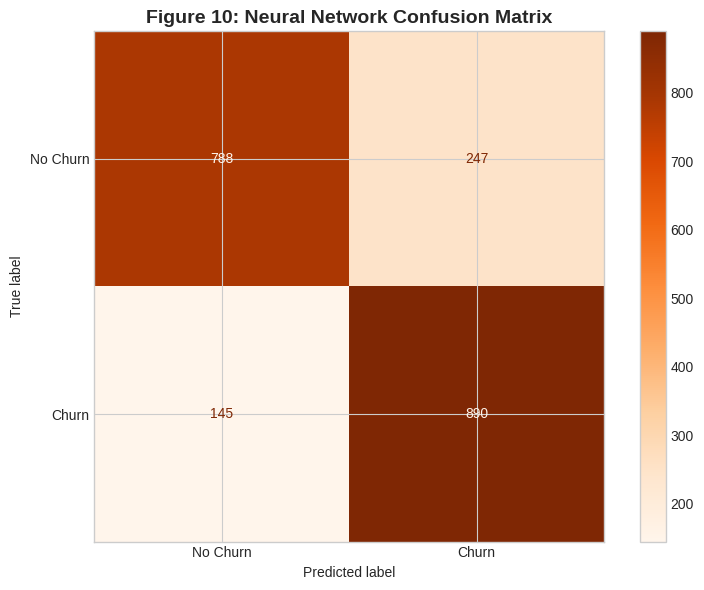

Figure 10 saved: fig10_nn_confusion_matrix.png

Confusion Matrix Breakdown:
  True Negatives (TN): 788
  False Positives (FP): 247
  False Negatives (FN): 145
  True Positives (TP): 890


In [37]:
# Figure 10: Neural Network Confusion Matrix
fig, ax = plt.subplots(figsize=(8, 6))

cm_nn = confusion_matrix(y_test, nn_test_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_nn, display_labels=['No Churn', 'Churn'])
disp.plot(cmap='Oranges', ax=ax, values_format='d')

plt.title('Figure 10: Neural Network Confusion Matrix', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.savefig('fig10_nn_confusion_matrix.png', dpi=300, bbox_inches='tight')
plt.show()

tn, fp, fn, tp = cm_nn.ravel()
print(f"Figure 10 saved: fig10_nn_confusion_matrix.png")
print(f"\nConfusion Matrix Breakdown:")
print(f"  True Negatives (TN): {tn}")
print(f"  False Positives (FP): {fp}")
print(f"  False Negatives (FN): {fn}")
print(f"  True Positives (TP): {tp}")

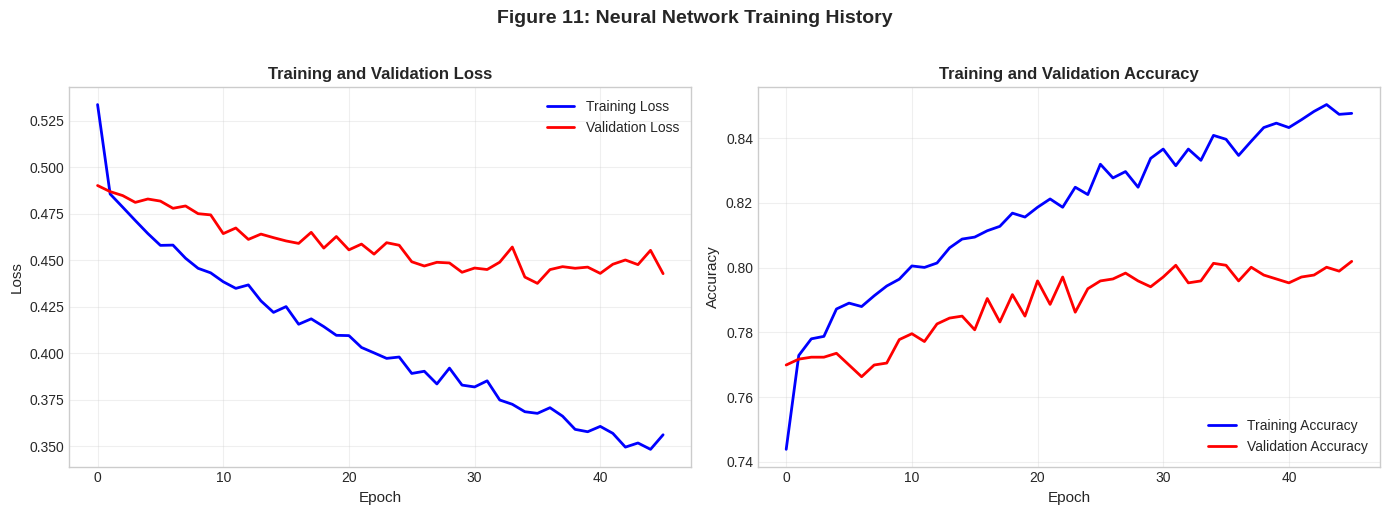

Figure 11 saved: fig11_nn_training_history.png


In [38]:
# Figure 11: Neural Network Training History
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss Plot
axes[0].plot(history.history['loss'], label='Training Loss', color='blue', linewidth=2)
axes[0].plot(history.history['val_loss'], label='Validation Loss', color='red', linewidth=2)
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Training and Validation Loss', fontsize=12, fontweight='bold')
axes[0].legend(loc='upper right')
axes[0].grid(True, alpha=0.3)

# Accuracy Plot
axes[1].plot(history.history['accuracy'], label='Training Accuracy', color='blue', linewidth=2)
axes[1].plot(history.history['val_accuracy'], label='Validation Accuracy', color='red', linewidth=2)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Accuracy', fontsize=11)
axes[1].set_title('Training and Validation Accuracy', fontsize=12, fontweight='bold')
axes[1].legend(loc='lower right')
axes[1].grid(True, alpha=0.3)

plt.suptitle('Figure 11: Neural Network Training History', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.savefig('fig11_nn_training_history.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 11 saved: fig11_nn_training_history.png")

---
# Model Comparison
---

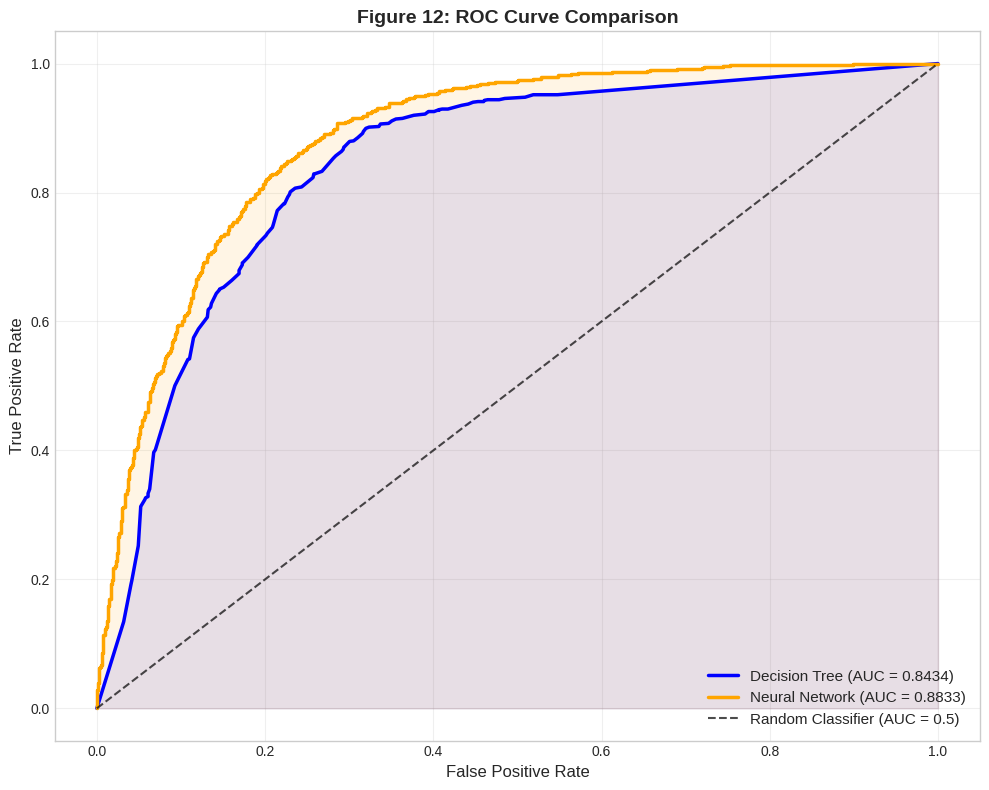

Figure 12 saved: fig12_roc_comparison.png


In [39]:
# Figure 12: ROC Curve Comparison
plt.figure(figsize=(10, 8))

# Calculate ROC curves
dt_fpr, dt_tpr, _ = roc_curve(y_test, dt_test_proba)
nn_fpr, nn_tpr, _ = roc_curve(y_test, nn_test_proba)

# Plot ROC curves
plt.plot(dt_fpr, dt_tpr, label=f'Decision Tree (AUC = {dt_roc_auc:.4f})',
         color='blue', linewidth=2.5)
plt.plot(nn_fpr, nn_tpr, label=f'Neural Network (AUC = {nn_roc_auc:.4f})',
         color='orange', linewidth=2.5)
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier (AUC = 0.5)', linewidth=1.5, alpha=0.7)

# Fill areas
plt.fill_between(dt_fpr, dt_tpr, alpha=0.1, color='blue')
plt.fill_between(nn_fpr, nn_tpr, alpha=0.1, color='orange')

plt.xlabel('False Positive Rate', fontsize=12)
plt.ylabel('True Positive Rate', fontsize=12)
plt.title('Figure 12: ROC Curve Comparison', fontsize=14, fontweight='bold')
plt.legend(loc='lower right', fontsize=11)
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('fig12_roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 12 saved: fig12_roc_comparison.png")

In [40]:
# Model Comparison Summary
print("=" * 70)
print("MODEL COMPARISON SUMMARY")
print("=" * 70)

comparison_df = pd.DataFrame({
    'Metric': ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC'],
    'Decision Tree': [dt_accuracy, dt_precision, dt_recall, dt_f1, dt_roc_auc],
    'Neural Network': [nn_accuracy, nn_precision, nn_recall, nn_f1, nn_roc_auc]
})
comparison_df['Difference'] = comparison_df['Neural Network'] - comparison_df['Decision Tree']
comparison_df['Better Model'] = comparison_df.apply(
    lambda row: 'Neural Network' if row['Difference'] > 0 else 'Decision Tree', axis=1
)

print("\n")
display(comparison_df.round(4))

MODEL COMPARISON SUMMARY




,Metric,Decision Tree,Neural Network,Difference,Better Model
0,Accuracy,0.7850,0.8106,0.0256,Neural Network
1,Precision,0.7620,0.7828,0.0208,Neural Network
2,Recall,0.8290,0.8599,0.0309,Neural Network
3,F1-Score,0.7941,0.8195,0.0254,Neural Network
4,ROC-AUC,0.8434,0.8833,0.0399,Neural Network


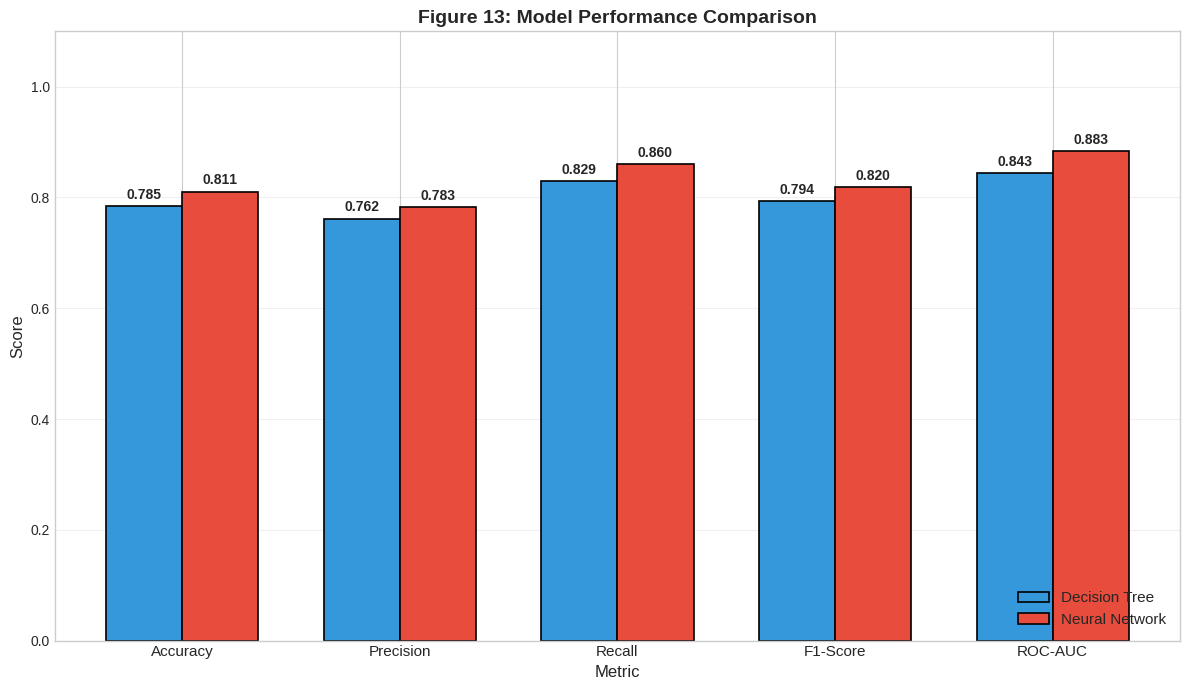

Figure 13 saved: fig13_model_comparison.png


In [41]:
# Figure 13: Model Performance Comparison Bar Chart
fig, ax = plt.subplots(figsize=(12, 7))

metrics = ['Accuracy', 'Precision', 'Recall', 'F1-Score', 'ROC-AUC']
dt_values = [dt_accuracy, dt_precision, dt_recall, dt_f1, dt_roc_auc]
nn_values = [nn_accuracy, nn_precision, nn_recall, nn_f1, nn_roc_auc]

x = np.arange(len(metrics))
width = 0.35

bars1 = ax.bar(x - width/2, dt_values, width, label='Decision Tree',
               color='#3498db', edgecolor='black', linewidth=1.2)
bars2 = ax.bar(x + width/2, nn_values, width, label='Neural Network',
               color='#e74c3c', edgecolor='black', linewidth=1.2)

# Add value labels on bars
def add_labels(bars):
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

add_labels(bars1)
add_labels(bars2)

ax.set_xlabel('Metric', fontsize=12)
ax.set_ylabel('Score', fontsize=12)
ax.set_title('Figure 13: Model Performance Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(metrics, fontsize=11)
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim(0, 1.1)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('fig13_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()
print("Figure 13 saved: fig13_model_comparison.png")

In [42]:
# Final Comparison Analysis
print("\n" + "=" * 70)
print("FINAL ANALYSIS")
print("=" * 70)

# Determine winner
nn_wins = sum([1 for dt, nn in zip(dt_values, nn_values) if nn > dt])
dt_wins = sum([1 for dt, nn in zip(dt_values, nn_values) if dt > nn])

if nn_wins > dt_wins:
    winner = "Neural Network"
    f1_improvement = ((nn_f1 - dt_f1) / dt_f1) * 100
else:
    winner = "Decision Tree"
    f1_improvement = ((dt_f1 - nn_f1) / nn_f1) * 100

print(f"\nMetrics won by Neural Network: {nn_wins}/5")
print(f"Metrics won by Decision Tree: {dt_wins}/5")
print(f"\nMost Suitable: {winner}")
print(f"\nF1-Score Improvement: {abs(f1_improvement):.1f}%")
print(f"ROC-AUC Difference: {abs(nn_roc_auc - dt_roc_auc):.4f}")

print("\n" + "-" * 70)
print("RECOMMENDATION:")
print("-" * 70)
print(f"The {winner} model is recommended for deployment based on overall")
print("performance across all evaluation metrics.")


FINAL ANALYSIS

Metrics won by Neural Network: 5/5
Metrics won by Decision Tree: 0/5

Most Suitable: Neural Network

F1-Score Improvement: 3.2%
ROC-AUC Difference: 0.0399

----------------------------------------------------------------------
RECOMMENDATION:
----------------------------------------------------------------------
The Neural Network model is recommended for deployment based on overall
performance across all evaluation metrics.


In [43]:
# Download all figures
print("=" * 70)
print("DOWNLOADING ALL FIGURES")
print("=" * 70)

figures = [
    'fig1_churn_distribution.png',
    'fig2_correlation_heatmap.png',
    'fig3_numerical_distributions.png',
    'fig4_boxplots.png',
    'fig5_churn_by_categories.png',
    'fig6_violin_plots.png',
    'fig7_smote_comparison.png',
    'fig8_dt_confusion_matrix.png',
    'fig9_dt_feature_importance.png',
    'fig10_nn_confusion_matrix.png',
    'fig11_nn_training_history.png',
    'fig12_roc_comparison.png',
    'fig13_model_comparison.png',
    'detailed_tenure_analysis.png',
    'detailed_monthlycharges_analysis.png',
    'detailed_totalcharges_analysis.png',
    'categorical_features_distribution.png',
    'churn_rate_by_categories_detailed.png',
    'numerical_features_churn_comparison.png'
]

print("\nDownloading figures...")
for fig in figures:
    try:
        files.download(fig)
        print(f"   {fig}")
    except Exception as e:
        print(f"  {fig} - Error: {str(e)}")

DOWNLOADING ALL FIGURES



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig1_churn_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig2_correlation_heatmap.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig3_numerical_distributions.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig4_boxplots.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig5_churn_by_categories.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig6_violin_plots.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig7_smote_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig8_dt_confusion_matrix.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig9_dt_feature_importance.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig10_nn_confusion_matrix.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig11_nn_training_history.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig12_roc_comparison.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   fig13_model_comparison.png
  detailed_tenure_analysis.png - Error: Cannot find file: detailed_tenure_analysis.png
  detailed_monthlycharges_analysis.png - Error: Cannot find file: detailed_monthlycharges_analysis.png
  detailed_totalcharges_analysis.png - Error: Cannot find file: detailed_totalcharges_analysis.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   categorical_features_distribution.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   churn_rate_by_categories_detailed.png


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

   numerical_features_churn_comparison.png
